# **Parkinson Disease Level Detection**

**Authors**

- Fabio Scielzo Ortiz (100374708)
- Javier Rodríguez Valverde (100505911)

## **Index**

1. **Objective**
2. **Requirements**
3. **Data description**
4. **Reading Speech Files**
5. **Feature extraction (Part 4 of Lab)**
6. **Classification based on GMM (Part 5 of Lab)**
7. **Classification based on Random Forest (Part 6 of Lab)**
8. **More in-depth analysis (Part 7 of Lab)**
    - **Inner evaluation**
    - **Selecting the best pipeline**
    - **Outer evaluation**

## **Objective**

The objective of this project is to implement an automatic system for **the determination of the severity level of  Parkinson's Disease (PD) of a patient by using speech features**. This system takes a speech utterance from an unknown speaker and provides their level of PD by analyzing their voice by means of machine learning techniques.

Patients with PD usually have difficulties in speaking because of reduced coordination of the muscles involved in the human speech production system. This causes distortions in the phoneme articulation, prosody, etc., diminishing the subject's speech intelligibility.


We have tried two main approaches along this project, one based on **speech features of fixed length** and another in **time-varying speech features (sequences of features)**.

In the both approaches we have considered different models, and in the first one several feature extraction methods. Then we have selected the best alternative overall, in terms of predictive performance.

The ***models*** considered are the following:

- In the approach based on **speech features of fixed length**: 

   - **Random Forest (RF)**
   - **Extreme Gradient Boosting (XGBoost)**
   - **Multi-layer Perceptron (MLP)**
   - Two **Neural Networks** implemented by mean of `PyTorch` 

- In the approach based on  **time-varying speech features (sequences of features)**:

  - **Gaussian Mixture Models (GMM)**
  - **Recurrent Neural Networks (RNN)**  implemented in `PyTorch`


And the ***feature extraction methods*** are the next ones:

- **Mel-Frequency Cepstrum Coefficients (MFCC)**
- **Chromagram**
- **Spectral Centroid**
- **Spectral Bandwith**
- **Spectral Contrast** 
- **Spectral Rolloff**
- **Zero Crossing Rate**
- **Tempogram**

## **Requirements**

In [1]:
import numpy  as np
import pandas as pd
import polars as pl
import sys
import matplotlib.pyplot as plt
import librosa  # package for speech and audio analysis
import IPython.display as ipd
import seaborn as sns
sns.set_style('whitegrid')
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from  xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from itertools import combinations
from skorch import NeuralNetClassifier
import torch
from torch import nn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

In [12]:
sys.path.insert(0, r"C:\Users\fscielzo\Documents\Packages\PyAudio_Package_Private")
from PyAudio.preprocessing import get_X_audio_features, get_X_tensor_audio_features

In [13]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyML_Package_Private')
from PyML.evaluation import SimpleEvaluation
from PyML.preprocessing import scaler

In [14]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyDL_Package_Private')
from PyDL.models import SimpleClassifier, AdvancedClassifier, RNN

In [5]:
advanced_NN = NeuralNetClassifier(
                module = AdvancedClassifier(input_dim=10, output_dim=2, 
                                            hidden_layers=[128, 256, 128], dropout_rate=0.3,
                                            random_state=123),
                criterion = torch.nn.CrossEntropyLoss,  # Use CrossEntropyLoss for multi-class classification
                optimizer = torch.optim.Adam,
                lr = 0.001,
                max_epochs = 100,
                batch_size = 64,
                verbose=False
)

In [6]:
simple_NN = NeuralNetClassifier(
                module = SimpleClassifier(input_dim=10, output_dim=2, 
                                          n_layers=3, random_state=123),
                criterion = torch.nn.CrossEntropyLoss,  # Use CrossEntropyLoss for multi-class classification
                optimizer = torch.optim.Adam,
                lr = 0.001,
                max_epochs = 100,
                batch_size = 64,
                verbose=False
)

In [7]:
RNN_model = NeuralNetClassifier(
    module=RNN(input_dim=10, output_dim=2, num_layers=3, hidden_size=128),
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=50,
    max_epochs=15,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=False
)

## **Data description**

We have a database composed by the following elements:

- **20 speakers** 

- **12 audios per speaker**

- We have speakers with different Parkinson disease levels:

    - **normal (0)** 
    - **slight (1)**
    - **moderate (2)**
    - **severe (3)**
    
    hat has been recorded at a **sampling frequency of 16000 Hz**.

The dataset has been manually annotated following a subset of the **Unified Parkinson’s Disease Rating Scale (UPDRS)**, a scoring scale utilized by neurologistics for clinical assessment of PD.



## **Reading Speech Files**

In this section we are going to show how to read speech files by mean od `librosa`.

### **Reading a class 0 (normal) speech**

Here we read a normal (0) speech.

In [13]:
# Reading a speech file from the database - Class 0

fs = 16000  # sampling frequency
audio_file = 'PDSpeechData/loc17/loc17_s01.wav'  # speech file

# 'audio_signal_1' is an array with the amplitude of the audio signal along the time:
audio_signal_1, sr = librosa.load(audio_file, sr=fs)

We have set a sampling frequency of 16000, this means that for each second we have 16000 values of amplitude. The time length of the read audio file is 13 seconds, so we have  approximately  13*16000 = 208000 points of amplitude. This amplitudes point are saved in the array `audio_signal_1`.


Each audio file contains the amplitude of the audio expressed in a continuous scale, and what `librosa.load(audio_file, sr=fs)` does is to extract fs (16000) points for each 1 second interval of amplitudes of the original file. Each 1 sec interval is a continues interval, therefore, with infinity values, and the algorithm selects 16000 samples equally spaced.

In [112]:
audio_signal_1

array([ 0.04125977,  0.05276489,  0.03128052, ..., -0.00030518,
       -0.00030518, -0.00033569], dtype=float32)

In [113]:
time_audio_signal_1 = 13
time_audio_signal_1 * fs

208000

In [114]:
audio_signal_1.shape

(216500,)

- Plotting the audio signal amplitudes along time

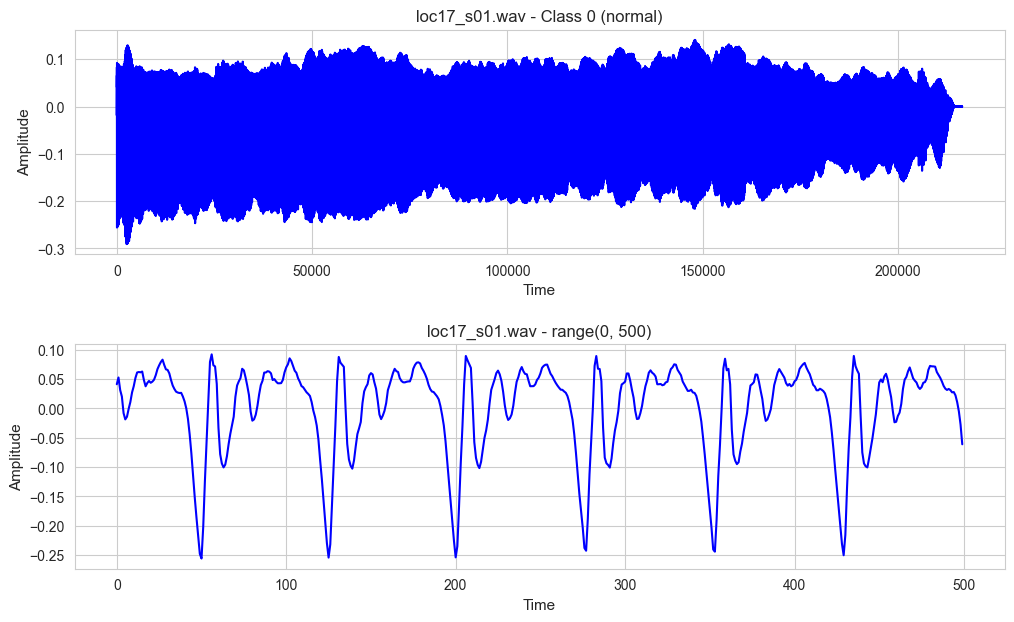

In [115]:
audio_signal = audio_signal_1
filter = range(0,500)
fig, axes = plt.subplots(2, 1, figsize=(12,7))
axes = axes.flatten()  

sns.lineplot(y=audio_signal, x=range(len(audio_signal)), color='blue', ax=axes[0])
sns.lineplot(y=audio_signal[filter], x=filter, color='blue', ax=axes[1])

axes[0].set_title(audio_file.split('/')[-1] + ' - Class 0 (normal)')
axes[1].set_title(audio_file.split('/')[-1] + f' - {str(filter)}')

for i in range(len(axes)):
    axes[i].set_ylabel('Amplitude', size=11)
    axes[i].set_xlabel('Time', size=11)
plt.subplots_adjust(hspace=0.4, wspace=0.5) 

- Displaying the audio file as sound:

In [116]:
ipd.Audio(audio_signal_1, rate=fs)

### **Reading a class 3 (severe) speech**

Now we read a severe (3) speech.

In [117]:
# Reading a speech file from the database - Class 3

fs = 16000  # sampling frequency
audio_file = 'PDSpeechData/loc18/loc18_s01.wav'  # speech file

audio_signal_2, sr = librosa.load(audio_file, sr=fs)
# 'audio_signal_2' is an array with the amplitude of the audio signal along the time

In [118]:
audio_signal_2

array([-0.25128174, -0.37490845, -0.24560547, ..., -0.04568481,
       -0.04675293, -0.04760742], dtype=float32)

In [119]:
time_audio_signal_2 = 7
time_audio_signal_2 * fs

112000

In [120]:
audio_signal_2.shape

(122500,)

- Plotting the audio signal amplitudes along time

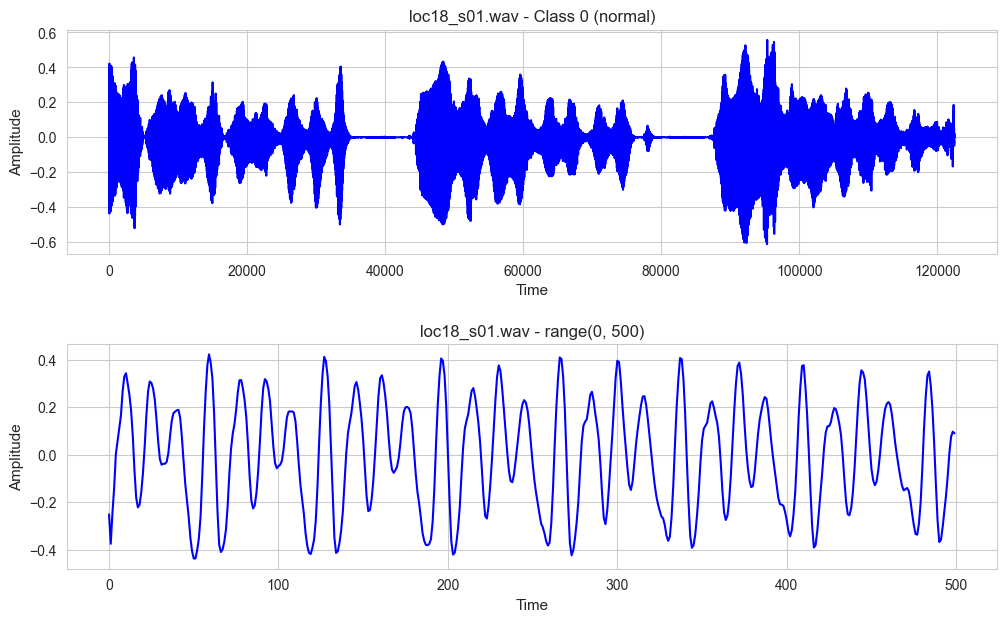

In [121]:
audio_signal = audio_signal_2
filter = range(0,500)
fig, axes = plt.subplots(2, 1, figsize=(12,7))
axes = axes.flatten()  

sns.lineplot(y=audio_signal, x=range(len(audio_signal)), color='blue', ax=axes[0])
sns.lineplot(y=audio_signal[filter], x=filter, color='blue', ax=axes[1])

axes[0].set_title(audio_file.split('/')[-1] + ' - Class 0 (normal)')
axes[1].set_title(audio_file.split('/')[-1] + f' - {str(filter)}')

for i in range(len(axes)):
    axes[i].set_ylabel('Amplitude', size=11)
    axes[i].set_xlabel('Time', size=11)
plt.subplots_adjust(hspace=0.4, wspace=0.5) 

- Displaying the audio file as sound:

In [122]:
# Play the audio data
ipd.Audio(audio_signal_2, rate=fs)

## **Feature extraction**

In the following section we show an example of feature extraction for the previous speech signal `audio_signal_2`.



The point is, given an audio signal, extract features that characterize it, to be used along with Machine Learning algorithms, in this case to classify a new signal in one of the four PD levels mentioned above.

We distinguish two types of audio features:

- **Time-varying features (sequencies)**

   - This type are suitable to be used with models that work well with sequential data, like Recurrent Neural Networks and Gaussian Mixture Models.

- **Fix length features**

  - This type is suitable  for models that work with tabular data, like Random Forest, XGBoost and Multi-Layer Perceptron Neural Networks.

  - This features are basically statistics computed on the  time-varying features.

The methods for features extraction that we are going to use along this projects are the following:

- Mel-Frequency Cepstrum Coefficients (MFCC)
- Chromagram
- Spectral Centroid
- Spectral Bandwith
- Spectral Contrast 
Spectral Rolloff
- Zero Crossing Rate
- Tempogram

These methods are applied directly to the amplitudes series of a given audio signal and return a matrix with the time-varying features for that signal. Then, we can retrieve a vector with the statistic about the features of that matrix, these will be the fixed length features of that audio signal.

This process can be done for all the $n$ available audio signals, then we obtain $n$ matrices with time-varying features.

Then, this $n$ matrices can be accommodated in a 3D array, also known as **tensor**, that can be used as input by different Machine Learning, typically deep learning algorithms, like Recurrent Neural Networks (RNN).

But these $n$ matrices (2D arrays) can also be transformed in vectors (1D arrays) computing statistics like mean or standard deviation for the features contained in those matrices. Then, we have $n$ 1D arrays that can be concatenated to build a 2D array that could be interpreted as a **predictor matrix** (tabular data) to be used as input by classic Machine Learning algorithms, that work well with tabular data.


### **Mel-Frequency Cepstrum Coefficients (MFCC)**

MFCCs are a feature representation that captures the power spectrum of an audio signal, using a cosine transform of a log power spectrum on a nonlinear Mel scale of frequency. This Mel scale aims to mimic the human ear's response more closely than the linearly-spaced frequency bands used in the typical Fourier transform. This makes MFCCs particularly useful for applications like speech recognition or music analysis, where the perception-like representation of audio can be more beneficial than purely physical representations.

The MFCC components refer to the number of coefficients extracted from each frame of the audio signal. The choice of the number of components is somewhat arbitrary but is based on empirical evidence suggesting that the first few coefficients (usually the first 12 to 20) capture most of the useful information about the spectral envelope of the audio signal. The higher coefficients, which represent finer details of the spectrum, are often discarded.


In this case, we want to compute a sequence of Mel-Frequency Cepstrum Coefficients (MFCC) with the following configuration:

- **Size of the analysis window = 32 ms = 0.032 secs**

- **Frame period or hop length = 8 ms = 0.008 secs**

- **Number of filters in the mel filterbank = 40**

- **Number of MFCC components = 20**

For doing that, we are going to use the function `mfcc` from the module *feature* of the `librosa` package. This function has, among others, the following input arguments:

* `y`: speech signal
* `sr`: sampling frequency
* `n_fft`: window size (in samples)
* `hop_length`: frame period or hop length (in samples)
* `n_mels`: number of filters in the mel filterbank
* `n_mfcc`: number of MFCC components

Note that in this function the window size and the hop length must be expressed in samples. Taking into account that the sampling frequency (fs) indicates that 1 second corresponds to fs samples (in our case, as fs=16000 Hz, 1 second corresponds to 16000 samples), the conversion from **seconds** to **samples** is performed by:

```
samples = seconds*fs = seconds*16000
```

In [5]:
# Specifying variables for feature extraction
fs = 16000 # Sampling frequency
wst = 0.032 # Window size (seconds)
fpt = 0.008 # Frame period (seconds)
nfft = int(np.ceil(wst*fs)) # Window size (samples)
fp = int(np.ceil(fpt*fs)) # Frame period (samples)
nbands = 40 # Number of filters in the filterbank
ncomp = 20 # Number of MFCC components

In [124]:
# Feature extraction with MFCC 
x_MFCC = librosa.feature.mfcc(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T

In [125]:
x_MFCC

array([[-1.5723482e+02,  8.1401794e+01, -1.0822573e+01, ...,
        -1.4883176e+00, -2.3103115e-01, -5.7656441e+00],
       [-1.4987587e+02,  8.2267227e+01, -1.5025454e+01, ...,
        -4.9614630e+00, -5.0628245e-01, -1.0207132e+01],
       [-1.5724088e+02,  7.8481644e+01, -2.0651829e+01, ...,
        -8.5300264e+00, -1.4817656e+00, -1.2810444e+01],
       ...,
       [-4.8450891e+02,  1.6448849e+01,  1.2042265e+01, ...,
         1.0532631e+00,  6.7879003e-01,  3.1149516e-01],
       [-4.8156741e+02,  2.0192478e+01,  1.4441982e+01, ...,
         8.4327966e-01, -4.1927201e-01,  1.3737071e-01],
       [-4.7447165e+02,  2.9626501e+01,  2.1557457e+01, ...,
         5.4327607e-01, -3.4168136e-01, -1.5610456e-01]], dtype=float32)

In [126]:
x_MFCC.shape

(1692, 20)

`x_MFCC` is a `time-samples x ncomp = 1692 x 20` matrix, where its columns represent features and its rows observations.

- `20` is the number of Mel-Frequency Cepstrum Coefficients (MFCC) components, and is defined apriori as a hyper-parameter.

- `1692` is the number of time-samples fort that audio signal, and is defined as the number of samples of the audio signal divided between the frame period (in samples).


In [127]:
ncomp

20

In [128]:
n_samples_audio_signal_1 = len(audio_signal_1)
time_samples_audio_signal_1 = np.ceil(n_samples_audio_signal_1 / fp)
time_samples_audio_signal_1

1692.0

The columns of `x_MFCC`, which are the MFCC components could be interpreted as features of the audio signal, and its rows as the value of these features along time, and this is why we called these features as 'time-varying' features.

It's important to realize that `x_MFCC` is the MFCC matrix for one single audio signal, concretely for `audio_signal_1`.

But we want to obtain this matrix for the available data, let say, for all the available audio signals, in order to build a tensor or a predictors matrix to be used along with Machine Learning models, to carry out the classification task of this project, which is our main goal.

#### **From MFCC matrices to tensor** 

The task is to transform the $n$ MFCC matrices (one per audio) into a tensor (3D array) of shape `n x ncomp x max-n_time_samples`. 

For doing that we are going to use our custom function `get_X_tensor_audio_features`, that takes a list of audio file paths, a method for features extraction  and the parameters for that method, then process the audio files as signals, and apply the specified feature extraction method on the signal, obtaining **time-varying features** of it. 

This process is repeated for each audio file, obtaining $n$ MFCC matrices of size `ncomp x max-n_time_samples`, and the results are allocated in a 3D array of size `n x ncomp x max-n_time_samples`, that is, in a tensor of size. The final output of out function is the desired tensor.

Later is explained why the las dimension of the tensor is `max-n_time_samples`.

We read all the audio file paths along with their belonging class, and accommodate them in a data-frame.

In [4]:
files_list_path = r'C:\Users\fscielzo\Documents\DataScience-GitHub\Audio Analysis\Parkinson_Severity_Classification\Data\Files_List.txt'
files_df = pl.read_csv(files_list_path, separator='\t', has_header=False, new_columns=['path', 'level'])

In [130]:
files_df.head(3)

path,level
str,i64
"""PDSpeechData/l…",0
"""PDSpeechData/l…",0
"""PDSpeechData/l…",0


We have 240 audio files.

In [131]:
files_df.shape

(240, 2)

Now we can process all those audio files, extract time-varying features form them and build a tensor to be used in ML models like RNN.

In this case we are using MFCC as features extraction method, with the parameters defined previously.

In [132]:
X_MFCC_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='MFCC', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

As you can see this is indeed a tensor, since it is a 3D array with shape `(240, 20, 4403)`.

This means that for each one of our 240 audios, we have a MFCC matrix, with time-varying features that characterize it.

In [133]:
X_MFCC_tensor

array([[[-3.25005737e+02, -3.13607208e+02, -3.10144470e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.67731781e+01,  7.59160614e+01,  7.93242340e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.46149426e+01,  1.50402470e+01,  1.77627831e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-4.79171467e+00, -1.09497318e+01, -9.35082436e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.61563778e+00, -1.05655603e+01, -6.97648907e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.39404225e-01, -1.94986522e+00,  3.36962867e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-3.77771057e+02, -3.72950775e+02, -3.70798340e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.37817211e+01,  1.93036613e+01,  2.15146694e+01, ...,
          0.00000000e+00,  0.00000000e

In [134]:
X_MFCC_tensor.shape

(240, 20, 4403)

For example, this is the MFCC matrix for our first audio file:

In [135]:
X_MFCC_tensor[0]

array([[-325.0057373 , -313.60720825, -310.14447021, ...,    0.        ,
           0.        ,    0.        ],
       [  66.7731781 ,   75.9160614 ,   79.32423401, ...,    0.        ,
           0.        ,    0.        ],
       [  14.61494255,   15.04024696,   17.76278305, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [  -4.79171467,  -10.94973183,   -9.35082436, ...,    0.        ,
           0.        ,    0.        ],
       [  -3.61563778,  -10.56556034,   -6.97648907, ...,    0.        ,
           0.        ,    0.        ],
       [   0.83940423,   -1.94986522,    3.36962867, ...,    0.        ,
           0.        ,    0.        ]])

In [136]:
X_MFCC_tensor[0].shape

(20, 4403)

As you can see there are zeros at the end of each row, this are the results of padding the MFCC matrix.

The point is that each audio has a different size MFCC matrix (in time-samples terms, since all of them have the same number of components), so, in order to allocate all of them in a 3D array we need to enforce the same size for all of them, and this is done by forcing all the MFCC to have the same number of time-samples, concretely the maximum one `(max-n_time_samples)`, let say, the one of the largest MFCC matrix. So, now all the MFCC matrices will have extra positions in the time-samples (except the largest one), and those extra positions   are filled with zeros. This process is called as padding, and is done automatically by our function `get_X_tensor_audio_features`.

#### **From MFCC matrices to predictors matrix (tabular data)**

The task is to transform the $n$ MFCC matrices (one per audio) into a predictors matrix (2D array) of shape `n x ncomp`. 

For doing this we are going to use aur custom function `get_X_audio_features`, that takes a list of audio file paths, a method for features extraction  and the parameters for that method, then process the audio files as signals, and apply the specified feature extraction method on the signal, obtaining **time-varying features** of it. Then **statistics** are computed for each feature along the time dimension, obtaining a vector (1D array) of size `ncomp`.

This process is repeated for each audio file, obtaining $n$ vectors, and the results are allocated in a 2D array of size `n x ncomp`, that is, a matrix. The final output of our function is the desired predictors matrix.

Here, as example, we compute two possible predictors (features) matrices using the MFCC method for feature extraction and two different statistics configurations, one with the mean and another with both the  mean and the standard deviation.

In [137]:
X_MFCC_stats_1 = get_X_audio_features(paths=files_df['path'], method='MFCC', stats='mean', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)
X_MFCC_stats_2 = get_X_audio_features(paths=files_df['path'], method='MFCC', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

These matrices has predictors as columns and observations/samples as rows. 

Since we are working with 240 audios these matrices will have 240 rows, and the number of predictors depends on the used statistics. 

If only one statistic us used, as in the first case, we will have a number of predictors equal to the number of components fixed for the features extraction method, in this case 20.

If we use a combination of several statistics, let say $k$, the number of predictors will be `k*ncomp`. 

In the first case, since we have used only the mean as statistics the number of predictors is equal to the number of MFCC components, so 20. These predictors represent the mean of the time-varying components for each audio. For example, the first predictors contains the mean of the first time-varying MFCC component (the mean of that component along time) for each one of the 240 available audios.

In the second case we have used two statistics, therefore the number of predictors is 40 (2*20), the first 20 predictors represent the mean of the 20 time-varying components for each audio file, and the next 20 predictors represent the standard deviation.

Is pretty obvious that this idea can be generalized, so, we can use any combination of statistics as well as of features extraction to build predictors matrices to be used along with ML algorithms in predictive scenarios like this. 

In the predictive part of this project we will explore these alternatives, both combining different statistics as well as features extraction methods.

***Note:*** when we talk about combining feature extraction methods what we mean is to obtain 
 matrices using different methods and then concatenate them to form a single predictors matrix that combines the information of them, which could improve the predictive performance of certain models.  This option  has been considered in the predictive part.

In [138]:
X_MFCC_stats_1

array([[-2.13158752e+02,  9.29840240e+01, -6.40546494e+01, ...,
        -2.17615294e+00,  2.29761638e-02, -5.47736108e-01],
       [-1.98984543e+02,  6.80483322e+01, -4.74277916e+01, ...,
         4.45366669e+00,  9.83190179e-01, -4.84144878e+00],
       [-2.40027390e+02,  5.97654343e+01, -2.60434890e+00, ...,
         7.12371826e-01, -3.60437250e+00, -7.20492887e+00],
       ...,
       [-2.91605225e+02,  8.18440247e+01,  2.95778332e+01, ...,
         1.58350534e+01,  1.41482115e+01,  1.16930342e+01],
       [-2.12697678e+02,  7.87770691e+01,  1.69434319e+01, ...,
        -4.82905912e+00,  2.94541955e+00,  1.33842838e+00],
       [-2.09183228e+02,  7.25918579e+01,  3.24228172e+01, ...,
        -1.01590958e+01,  1.20261431e+00, -3.76960754e+00]], dtype=float32)

In [139]:
X_MFCC_stats_1.shape

(240, 20)

In [140]:
X_MFCC_stats_2

array([[-213.15875  ,   92.984024 ,  -64.05465  , ...,    7.095715 ,
           6.177743 ,    5.351471 ],
       [-198.98454  ,   68.04833  ,  -47.42779  , ...,    6.012935 ,
           5.59839  ,    4.8842993],
       [-240.02739  ,   59.765434 ,   -2.604349 , ...,    5.646291 ,
           5.4601407,    6.5454264],
       ...,
       [-291.60522  ,   81.844025 ,   29.577833 , ...,   13.644189 ,
          11.3029785,    9.850929 ],
       [-212.69768  ,   78.77707  ,   16.943432 , ...,    2.2818298,
           2.13314  ,    2.4295764],
       [-209.18323  ,   72.59186  ,   32.422817 , ...,    2.3896735,
           3.0300555,    2.1277957]], dtype=float32)

In [141]:
X_MFCC_stats_2.shape

(240, 40)

#### **Example of predictors matrix that combines different features extraction methods and statistics**

In [142]:
X_MFCC_stats = get_X_audio_features(paths=files_df['path'], method='MFCC', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)
X_chroma_stats = get_X_audio_features(paths=files_df['path'], method='chroma', stats='median-std', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

In [143]:
X_MFCC_stats.shape

(240, 40)

In [144]:
X_chroma_stats.shape

(240, 24)

In [145]:
X_combined = np.concatenate((X_MFCC_stats, X_chroma_stats), axis=1)
X_combined

array([[-2.1315875e+02,  9.2984024e+01, -6.4054649e+01, ...,
         2.7830657e-01,  3.4890896e-01,  1.7714919e-01],
       [-1.9898454e+02,  6.8048332e+01, -4.7427792e+01, ...,
         3.7769288e-01,  1.5670222e-01,  2.0125444e-01],
       [-2.4002739e+02,  5.9765434e+01, -2.6043489e+00, ...,
         1.8112896e-01,  2.1978563e-01,  3.3394688e-01],
       ...,
       [-2.9160522e+02,  8.1844025e+01,  2.9577833e+01, ...,
         3.7720391e-01,  3.9648506e-01,  4.0834939e-01],
       [-2.1269768e+02,  7.8777069e+01,  1.6943432e+01, ...,
         4.0676277e-02,  7.6654352e-02,  9.9300966e-02],
       [-2.0918323e+02,  7.2591858e+01,  3.2422817e+01, ...,
         2.8915258e-02,  3.2900050e-02,  3.4263603e-02]], dtype=float32)

In [146]:
X_combined.shape

(240, 64)

### **Chromagram**

Chroma features are a powerful tool for analyzing music. They capture the essence of harmony, melody, and tonality of musical signals. By projecting the entire spectrum onto 12 different bins representing the 12 distinct semitones (or chromatic scale) in Western music, chroma features provide a high-level representation of music or audio in terms of octaves. This can be particularly useful for capturing the musical aspects of speech which could correlate with disease states.


In [147]:
# Feature extraction with Chromagram 
x_chroma = librosa.feature.chroma_stft(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [148]:
x_chroma

array([[0.76920897, 0.776894  , 0.34586996, ..., 1.        , 0.63658094,
        0.48888198],
       [0.5365836 , 0.57130456, 0.07953023, ..., 1.        , 0.46217796,
        0.23196535],
       [0.59507215, 0.52440584, 0.04829044, ..., 1.        , 0.4172734 ,
        0.19030185],
       ...,
       [0.9172087 , 0.7431331 , 0.6895156 , ..., 0.8187049 , 0.9443104 ,
        1.        ],
       [0.9935548 , 0.934088  , 0.8525207 , ..., 0.9157632 , 0.99230087,
        1.        ],
       [0.93939584, 1.        , 0.96149266, ..., 0.8938448 , 0.92480946,
        0.94353443]], dtype=float32)

In [149]:
x_chroma.shape

(1692, 12)

#### **From Chroma matrices to tensor** 

In [150]:
X_chroma_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='chroma', sr=fs, n_fft=nfft, hop_length=fp)

X_chroma_tensor

In [151]:
X_chroma_tensor.shape

(240, 12, 4403)

#### **From Chroma matrices to predictors matrix (tabular data)**

In [152]:
X_chroma_stats = get_X_audio_features(paths=files_df['path'], method='chroma', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [153]:
X_chroma_stats

array([[0.32919034, 0.48674947, 0.13121736, ..., 0.27830657, 0.34890896,
        0.17714919],
       [0.11371233, 0.19766188, 0.09701521, ..., 0.37769288, 0.15670222,
        0.20125444],
       [0.5519331 , 0.1438093 , 0.08654997, ..., 0.18112896, 0.21978563,
        0.33394688],
       ...,
       [0.25067928, 0.23875663, 0.26547787, ..., 0.3772039 , 0.39648506,
        0.4083494 ],
       [0.3393735 , 0.5189489 , 0.7807806 , ..., 0.04067628, 0.07665435,
        0.09930097],
       [0.30499187, 0.47429892, 0.7501884 , ..., 0.02891526, 0.03290005,
        0.0342636 ]], dtype=float32)

In [154]:
X_chroma_stats.shape

(240, 24)

### **Spectral Centroid**

The Spectral Centroid represents the center of mass of the spectrum, providing a measure of the brightness of a sound. It is calculated as the weighted mean of the frequencies present in the sound, with their magnitudes as the weights. This feature gives an idea of how high or low the majority of the energy is in a sound spectrum.


In [155]:
# Feature extraction with spectral centroid 
x_spectral_centroid = librosa.feature.spectral_centroid(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [156]:
x_spectral_centroid

array([[1173.49156085],
       [1173.44240948],
       [1225.6018241 ],
       ...,
       [2030.97788411],
       [2028.13073426],
       [1640.92396239]])

In [157]:
x_spectral_centroid.shape

(1692, 1)

#### **From Spectral Centroid matrices to tensor** 

In [158]:
X_spectral_centroid_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_centroid', sr=fs, n_fft=nfft, hop_length=fp)

In [159]:
X_spectral_centroid_tensor

array([[[ 860.68242317,  737.32612638,  702.74733212, ...,
            0.        ,    0.        ,    0.        ]],

       [[1722.98555129, 1677.03902985, 1615.59102764, ...,
            0.        ,    0.        ,    0.        ]],

       [[1479.32504338, 1345.68771268, 1360.28338621, ...,
            0.        ,    0.        ,    0.        ]],

       ...,

       [[ 663.09360913,  586.61483978,  520.02672314, ...,
            0.        ,    0.        ,    0.        ]],

       [[1086.38030366,  971.71842423,  898.1939858 , ...,
            0.        ,    0.        ,    0.        ]],

       [[ 796.84943399,  704.26379079,  679.87846212, ...,
            0.        ,    0.        ,    0.        ]]])

In [160]:
X_spectral_centroid_tensor.shape

(240, 1, 4403)

#### **From Spectral Centroid matrices to predictors matrix** 

In [161]:
X_spectral_centroid_stats = get_X_audio_features(paths=files_df['path'], method='spectral_centroid', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [162]:
X_spectral_centroid_stats

array([[1222.51022012,  106.02869666],
       [1352.95675704,  292.90811358],
       [1573.29651356,  452.12319515],
       [1148.70689305,  102.08901252],
       [1030.46170316,  187.55238243],
       [1295.44084773,  208.27129492],
       [1263.05181668,  248.44794161],
       [1003.50312509,  133.57028631],
       [1070.73699491,  129.43194965],
       [1069.19199417,  149.36018421],
       [ 770.5005775 ,   59.60935519],
       [ 453.24031129,   29.71792047],
       [1344.7035196 ,  725.68509036],
       [1336.46868934,  608.80623466],
       [1227.09023004,  106.67904364],
       [1434.53104501,  117.39653373],
       [1932.02713538,  170.23029854],
       [ 932.59136027,  124.93733827],
       [ 696.62066277,  276.71068651],
       [1963.60256868,  720.26894443],
       [1915.64251365,  665.98189964],
       [ 919.65891344,  431.09062568],
       [1187.01412327,  447.66393129],
       [1199.32941239,  480.20315422],
       [ 852.61529121,  514.50788938],
       [ 546.81791865,  5

In [163]:
X_spectral_centroid_stats.shape

(240, 2)

### **Spectral Bandwidth**

Spectral Bandwidth measures the width of a band of frequencies and is defined as the width of the range of frequencies at which the magnitude of the spectrum is greater than a certain percentage of the peak magnitude. It reflects the spread of the spectrum and can indicate the complexity of a sound. A wider bandwidth signifies a noise-like or complex sound, while a narrow bandwidth indicates a tonal or simple sound.


In [164]:
# Feature extraction with spectral bandwith 
x_spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [165]:
x_spectral_bandwidth

array([[1309.30089921],
       [1255.1158018 ],
       [1275.03885178],
       ...,
       [2427.90186889],
       [2420.073342  ],
       [2256.56008742]])

In [166]:
x_spectral_bandwidth.shape

(1692, 1)

#### **From Spectral Bandwidth matrices to tensor** 

In [167]:
X_spectral_bandwidth_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_bandwidth', sr=fs, n_fft=nfft, hop_length=fp)

In [168]:
X_spectral_bandwidth_tensor

array([[[1143.32497568,  942.13602371,  870.97126742, ...,
            0.        ,    0.        ,    0.        ]],

       [[1785.06408858, 1760.67818379, 1734.84937353, ...,
            0.        ,    0.        ,    0.        ]],

       [[1574.27623182, 1486.74798403, 1545.91856   , ...,
            0.        ,    0.        ,    0.        ]],

       ...,

       [[ 901.28159703,  722.00737352,  537.66098854, ...,
            0.        ,    0.        ,    0.        ]],

       [[1617.36931068, 1553.21232249, 1469.45092787, ...,
            0.        ,    0.        ,    0.        ]],

       [[1417.14548475, 1323.33541644, 1265.27486656, ...,
            0.        ,    0.        ,    0.        ]]])

In [169]:
X_spectral_bandwidth_tensor.shape

(240, 1, 4403)

#### **From Spectral Bandwidth matrices to predictors matrix (tabular data)**

In [170]:
X_spectral_bandwidth_stats = get_X_audio_features(paths=files_df['path'], method='spectral_bandwidth', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [171]:
X_spectral_bandwidth_stats

array([[ 547.71039463,  190.68833226],
       [ 949.60789304,  210.65348963],
       [1257.37962494,  221.11233883],
       [ 655.10901947,  266.61427025],
       [1036.72287665,  183.3495748 ],
       [1087.49948991,  499.1671853 ],
       [1112.26886734,  453.83392324],
       [1008.52278684,  169.65089348],
       [1136.31978971,  114.58698542],
       [1369.45105255,  137.89868859],
       [ 733.60358082,   90.93676414],
       [ 600.8755911 ,   55.60126607],
       [1797.74599018,  734.56558902],
       [1776.10775885,  612.33648523],
       [ 944.46518321,  149.55301631],
       [1434.2496765 ,  105.46849527],
       [1954.60189389,  100.56700799],
       [ 910.6004008 ,  154.15121229],
       [ 765.39650212,  290.37160189],
       [1983.59218098,  620.01437049],
       [1981.69727227,  581.72095076],
       [ 998.51875333,  408.45410957],
       [1450.18425688,  454.85092884],
       [1518.25136553,  482.11063008],
       [1094.91762071,  458.69315579],
       [ 781.96866483,  4

In [172]:
X_spectral_bandwidth_stats.shape

(240, 2)

### **Spectral Contrast**

Spectral Contrast considers the difference in amplitude between peaks and valleys in the spectrum. This feature can be used to distinguish between different types of sound textures and timbres, as it effectively captures the dynamics of the spectral peaks and troughs over time.


In [173]:
# Feature extraction with Spectral Contrast 
x_spectral_contrast = librosa.feature.spectral_contrast(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [174]:
x_spectral_contrast

array([[ 5.63810593,  5.66707538,  6.30149297, ..., 13.96765089,
        12.25343919, 10.17588324],
       [ 6.21691956, 11.38575072, 11.8819769 , ..., 21.75429392,
        18.58376962, 15.36240143],
       [25.49436508, 18.267316  , 25.67031318, ..., 19.25143146,
        17.4834322 , 15.83951655],
       ...,
       [ 9.64391107,  3.7931424 , 10.92962245, ..., 17.23052401,
        15.0653737 , 11.47613243],
       [11.83635255, 10.54209236,  8.97554807, ..., 17.5021864 ,
        10.951186  , 12.79228362],
       [ 8.21206286,  2.71809055,  4.90784151, ..., 17.91953245,
        11.35885709, 12.94873939]])

In [175]:
x_spectral_contrast.shape

(1692, 7)

#### **From Spectral Contrast matrices to tensor** 

In [176]:
X_spectral_contrast_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_contrast', sr=fs, n_fft=nfft, hop_length=fp)

In [177]:
X_spectral_contrast_tensor

array([[[ 5.11662149, 10.292627  , 18.93497539, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.59230729, 15.67208379,  8.04153712, ...,  0.        ,
          0.        ,  0.        ],
        [ 8.45520947, 17.5710727 , 18.92689921, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [12.37949689, 17.93070151, 20.61663416, ...,  0.        ,
          0.        ,  0.        ],
        [19.41221672, 15.34366631, 17.42559859, ...,  0.        ,
          0.        ,  0.        ],
        [17.22184445, 15.558392  , 17.60068867, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 8.85085044,  9.03121079, 11.46311676, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.52008624, 12.60085564,  4.4187557 , ...,  0.        ,
          0.        ,  0.        ],
        [ 6.68093446,  8.71320422, 13.95862644, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [16.7197144 , 13.70447852, 10.81675158, ...,  

In [178]:
X_spectral_contrast_tensor.shape

(240, 7, 4403)

#### **From Spectral Contrast matrices to predictors matrix (tabular data)**

In [179]:
X_spectral_contrast_stats = get_X_audio_features(paths=files_df['path'], method='spectral_contrast', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [180]:
X_spectral_contrast_stats

array([[15.06088705, 13.66975386, 21.81056366, ...,  4.84396642,
         4.33531148,  3.91902237],
       [10.96765446, 10.62080312, 21.04077107, ...,  4.59791976,
         4.76635799,  3.87400562],
       [14.57345365, 13.03160549, 20.7638555 , ...,  5.36559019,
         4.00373309,  5.56484739],
       ...,
       [ 8.84012428, 20.74519205, 22.22548112, ...,  3.60031112,
         4.46534307,  5.43222996],
       [22.70844871, 13.80892128, 13.44845706, ...,  3.08630459,
         2.73138099,  4.70273429],
       [24.06449453, 14.47909753, 17.42508059, ...,  3.08591616,
         2.60190525,  3.64455257]])

In [181]:
X_spectral_contrast_stats.shape

(240, 14)

### **Spectral Rolloff**

Spectral Rolloff is a measure of the shape of the signal. It represents the frequency below which a certain percentage of the total spectral energy, typically between 85% and 95%, is contained. This can indicate whether the sound is noise-like or tone-like.


In [182]:
# Feature extraction with spectral rolloff 
x_spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_signal_1, sr=fs, n_fft=nfft, hop_length=fp).T

In [183]:
x_spectral_rolloff

array([[1750.  ],
       [1687.5 ],
       [1718.75],
       ...,
       [5468.75],
       [5250.  ],
       [4562.5 ]])

In [184]:
x_spectral_rolloff.shape

(1692, 1)

#### **From Spectral Rolloff matrices to tensor** 

In [185]:
X_spectral_rolloff_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='spectral_rolloff', sr=fs, n_fft=nfft, hop_length=fp)

In [186]:
X_spectral_rolloff_tensor

array([[[1375.  , 1312.5 , 1281.25, ...,    0.  ,    0.  ,    0.  ]],

       [[3781.25, 3750.  , 3656.25, ...,    0.  ,    0.  ,    0.  ]],

       [[3031.25, 2750.  , 2906.25, ...,    0.  ,    0.  ,    0.  ]],

       ...,

       [[ 843.75,  750.  ,  750.  , ...,    0.  ,    0.  ,    0.  ]],

       [[2343.75, 1843.75, 1593.75, ...,    0.  ,    0.  ,    0.  ]],

       [[1406.25,  937.5 ,  781.25, ...,    0.  ,    0.  ,    0.  ]]])

In [187]:
X_spectral_rolloff_tensor.shape

(240, 1, 4403)

#### **From Spectral Rolloff matrices to tensor** 

In [188]:
X_spectral_rolloff_stats = get_X_audio_features(paths=files_df['path'], method='spectral_rolloff', stats='mean-std', sr=fs, n_fft=nfft, hop_length=fp)

In [189]:
X_spectral_rolloff_stats

array([[1578.6367205 ,  294.68382051],
       [2307.13619403,  645.09551762],
       [2839.43103941,  709.64216797],
       [1382.05467372,  513.57783209],
       [1389.07657658,  490.49725542],
       [2164.73642173,  946.00923455],
       [2131.14017572,  893.32214866],
       [1198.98875753,  441.14167795],
       [1719.21762126,  266.29955367],
       [1973.86210005,  596.13730246],
       [ 935.67607004,   58.1070769 ],
       [ 559.38546901,   43.88905301],
       [3432.1086262 , 2201.60451981],
       [3117.26238019, 2041.97472162],
       [1454.17764396,  311.29167221],
       [2514.0600159 ,  344.8225258 ],
       [3772.02406923,  242.67752925],
       [1033.64672482,  314.1257139 ],
       [ 857.72165698,  737.38720186],
       [4216.0543131 , 1976.77369894],
       [4163.7879393 , 1871.63426645],
       [1150.74325951,  957.16552888],
       [1879.84330484, 1069.92905233],
       [1613.3592832 , 1206.71699409],
       [1071.52650823, 1173.53613121],
       [ 742.73830935, 12

In [190]:
X_spectral_rolloff_stats.shape

(240, 2)

### **Zero Crossing Rate**

The Zero Crossing Rate is the rate at which the signal changes from positive to negative or back. This feature is often used to measure the noisiness or the frequency content of a sound. A higher zero-crossing rate indicates a noisier signal or a higher frequency content.

In [191]:
# Feature extraction with spectral centroid 
x_zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_signal_1, hop_length=fp).T

In [192]:
x_zero_crossing_rate

array([[0.0390625 ],
       [0.04443359],
       [0.04882812],
       ...,
       [0.04443359],
       [0.04443359],
       [0.04443359]])

In [193]:
x_zero_crossing_rate.shape

(1692, 1)

#### **From Zero Crossing Rate matrices to tensor** 

In [194]:
X_zero_crossing_rate_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='zero_crossing_rate', hop_length=fp)

In [195]:
X_zero_crossing_rate_tensor

array([[[0.03857422, 0.04638672, 0.05566406, ..., 0.        ,
         0.        , 0.        ]],

       [[0.04882812, 0.05175781, 0.05566406, ..., 0.        ,
         0.        , 0.        ]],

       [[0.03125   , 0.03466797, 0.03759766, ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.02294922, 0.02587891, 0.02880859, ..., 0.        ,
         0.        , 0.        ]],

       [[0.00927734, 0.01074219, 0.01171875, ..., 0.        ,
         0.        , 0.        ]],

       [[0.01123047, 0.01220703, 0.015625  , ..., 0.        ,
         0.        , 0.        ]]])

In [196]:
X_zero_crossing_rate_tensor.shape

(240, 1, 4403)

#### **From Zero Crossing Rate matrices to predictors matrix** 

In [197]:
X_zero_crossing_rate_stats = get_X_audio_features(paths=files_df['path'], method='zero_crossing_rate', stats='mean-std', hop_length=fp)

In [198]:
X_zero_crossing_rate_stats

array([[0.13968108, 0.01811889],
       [0.12713428, 0.05410704],
       [0.16139104, 0.09023381],
       [0.13278552, 0.0150368 ],
       [0.06845982, 0.01230139],
       [0.12291739, 0.02418128],
       [0.11398559, 0.03383005],
       [0.04721614, 0.0100022 ],
       [0.06379654, 0.00702339],
       [0.03594709, 0.00396019],
       [0.06673346, 0.00343725],
       [0.03630212, 0.00146984],
       [0.06123172, 0.03862254],
       [0.05755557, 0.03619177],
       [0.11102839, 0.01048388],
       [0.06200357, 0.00509845],
       [0.04921273, 0.01197553],
       [0.06549767, 0.00737761],
       [0.05590522, 0.01658055],
       [0.12777993, 0.04488347],
       [0.11122282, 0.03122729],
       [0.05421168, 0.02222161],
       [0.02710364, 0.03646258],
       [0.0251287 , 0.0306713 ],
       [0.02515645, 0.02913848],
       [0.02123953, 0.02857775],
       [0.07877582, 0.04501191],
       [0.06794651, 0.0396902 ],
       [0.10538364, 0.03681736],
       [0.08328533, 0.03037691],
       [0.

In [199]:
X_zero_crossing_rate_stats.shape

(240, 2)

### **Tempogram**

A tempogram provides a time-tempo representation, showing how the tempo of a music piece or any audio signal varies over time. It is essentially a two-dimensional feature that maps tempo changes over time, offering a detailed view of the rhythmic dynamics within the audio. This analysis is crucial for understanding the structure and expression in music, as well as the articulation in speech or other sounds.

In [200]:
# Feature extraction with tempogram
x_tempogram = librosa.feature.tempogram(y=audio_signal_1, hop_length=fp).T

In [201]:
x_tempogram

array([[ 1.00000000e+00,  9.41933158e-01,  8.76072103e-01, ...,
         1.59134570e-17, -3.85780776e-17,  6.93578724e-17],
       [ 1.00000000e+00,  9.42431885e-01,  8.76818837e-01, ...,
        -7.22920084e-17, -5.24033103e-17, -2.94649892e-17],
       [ 1.00000000e+00,  9.42927130e-01,  8.77559350e-01, ...,
         2.42083309e-17,  4.45072418e-17,  6.77565953e-17],
       ...,
       [ 1.00000000e+00,  9.82748236e-01,  9.40765518e-01, ...,
         1.59796469e-13,  1.67667967e-14, -6.19583679e-17],
       [ 1.00000000e+00,  9.82782184e-01,  9.40875757e-01, ...,
         1.23167723e-13,  1.18727972e-14, -2.76223874e-17],
       [ 1.00000000e+00,  9.82816140e-01,  9.40986261e-01, ...,
         8.18619518e-14,  6.58631321e-15, -5.36289546e-17]])

In [202]:
x_tempogram.shape

(1692, 384)

#### **From Tempogram matrices to tensor** 

In [203]:
X_tempogram_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='tempogram', sr=fs, hop_length=fp)

In [204]:
X_tempogram_tensor

array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.74025825e-01,  9.73998168e-01,  9.73970572e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.24148727e-01,  9.23955753e-01,  9.23763154e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.28282802e-17,  1.08569700e-16,  1.05896581e-16, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.90230469e-17,  2.06738282e-17,  7.99315540e-17, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.64078887e-17,  3.83782012e-17,  8.48954562e-17, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.53294547e-01,  9.53346317e-01,  9.53398304e-01, ...,
          0.00000000e+00,  0.00000000e

In [205]:
X_tempogram_tensor.shape

(240, 384, 4403)

#### **From Tempogram matrices to predictors matrix** 

In [206]:
X_tempogram_stats = get_X_audio_features(paths=files_df['path'], method='tempogram', stats='mean-std', sr=fs, hop_length=fp)

In [207]:
X_tempogram_stats

array([[1.00000000e+00, 9.82917312e-01, 9.40125605e-01, ...,
        1.97084272e-10, 2.59539915e-11, 9.25080531e-17],
       [1.00000000e+00, 9.82942999e-01, 9.42317549e-01, ...,
        1.96826479e-10, 2.51983908e-11, 9.82804325e-17],
       [1.00000000e+00, 9.88717836e-01, 9.62690178e-01, ...,
        2.05286095e-10, 2.61386952e-11, 1.08429054e-16],
       ...,
       [1.00000000e+00, 9.84447901e-01, 9.48210334e-01, ...,
        1.78410464e-11, 2.02061978e-12, 8.59678112e-17],
       [1.00000000e+00, 9.88605317e-01, 9.69314379e-01, ...,
        1.18753587e-10, 1.49967598e-11, 1.25303448e-16],
       [1.00000000e+00, 9.90035415e-01, 9.72834162e-01, ...,
        1.21425552e-10, 1.53642920e-11, 1.30194034e-16]])

In [208]:
X_tempogram_stats.shape

(240, 768)


## **Classification based on GMM**




The PD level classification system based on GMM consists of two main stages:

* **Training phase**

* **Test phase**

In this case, the **time-varying features** will be used.

### Training phase 

In this stage, the models of the different PD levels are built. For doing that, the following steps must be done:

*	Reading of the training list (***“Train_List.txt”***).

* For each class (recall that, as mentioned in Section 2, there are four levels or classes in the dataset):

> *	**Feature extraction**. As baseline features, we recommend the use of the conventional **MFCC parameters**, setting **the window size, the frame period, the number of mel bands and the number of cepstral components to 32 ms, 8 ms, 40, and 20, respectively** (see Section 4.1).

> * **GMM models building.** The **GaussianMixture** function from the *mixture* module of the *sklearn* package, which implements the EM algorithm, can be used for this purpose. Use **8 gaussians** per model and **diagonal covariances**.

At the end of this process, a set of GMM models (one model per PD level) is generated. Note that in this stage, only the training material can be used (listed in ***“Train_List.txt”***).




In [212]:
# --------------------------------------------------------------------
# Training stage
# --------------------------------------------------------------------

##################################
# - FILL THE VALUES OF THE FOLLOWING CONFIGURATION VARIABLES
##################################

nomlist_train = r'Data\Train_List.txt'
nomlist_test = r'Data\Test_List.txt'
print("Training list: " + nomlist_train)
print("Test list : " + nomlist_test)

# Configuration variables for the training stage
# Number of gaussians in the GMM models
ngauss = 8

# Reading of the training list
# The format of the list (per line) is,
# name_of_speech_file   updr_level
data_train = pd.read_csv(nomlist_train, sep = '\t', header = None,
                         names = ['id_file', 'updrs_label'])
data_train.head()

# Number of training files
nfiles_train = len(data_train)
print('Number of training files =', nfiles_train)

# Classes
classes = np.sort(data_train['updrs_label'].unique())

nclasses = len(classes)
print('Classes:', classes)

# GMM models building
models = []
for i in classes:

  # Selection of the training files corresponding to PD level (class) "i"
  data_train_class = data_train.loc[data_train['updrs_label'] == classes[i]]
  print('Loading data of class', classes[i], len(data_train_class))

  # Loop for each training file of class "i"
  feat_train = {}  ## features for all training files of class "i"
  for k in data_train_class.index:

    # Loading of the training speech file
    speech_name = data_train['id_file'][k]
    x, fs = librosa.load(speech_name, sr=fs)

    # Feature extraction
    feat = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

    # Concatenation of the computed features in the matrix "feat_train" that
    # contains the features of all training files belonging to class "i"
    if k == data_train_class.index[0]:
      feat_train = feat
    else:
      feat_train = np.hstack([feat_train, feat])

  print('Dimensions of training features for class', i, np.shape(feat_train))

  # GMM model building for PD level (class) "i"
  gmm = GaussianMixture(n_components=ngauss, covariance_type='diag')
  gmm.fit(feat_train.T)
  models.append(gmm)
  print(feat_train.shape)

# --------------------------------------------------------------------

Training list: Data\Train_List.txt
Test list : Data\Test_List.txt
Number of training files = 140
Classes: [0 1 2 3]
Loading data of class 0 42
Dimensions of training features for class 0 (20, 68191)


(20, 68191)
Loading data of class 1 42
Dimensions of training features for class 1 (20, 66664)
(20, 66664)
Loading data of class 2 35
Dimensions of training features for class 2 (20, 52276)
(20, 52276)
Loading data of class 3 21
Dimensions of training features for class 3 (20, 17866)
(20, 17866)


### Test phase and evaluation

In the **test stage**, the predicted PD level is obtained following the next steps:

*	Loading of the test list (***“Test_List.txt”***).

* For each test file:

> *	**Feature extraction**. We extract MFCC parameters with the same configuration as in the training stage in Section 5.1.

> * **Log-likelihood computation of each model for the current test file.**
We have to compute the log-likelihood of the test MFCCs given each one of the 4 PD level models obtained in the training stage. The **score** function can be used for this purpose.

> * **Selection of the predicted PD level**. We select the predicted PD level according to the model which achieves the maximum log-likelihood.

Finally, in the **evaluation stage**, the performance of the system is measured in terms of the **accuracy** (percentage of correctly classified test files with respect to the total number of test files). Also, the **confusion matrix** should be reported.




In [214]:
# --------------------------------------------------------------------
# Test stage
# --------------------------------------------------------------------

# Reading of the test list
# The format of the list (per line) is,
# name_of_speech_file   updrs_level
data_test = pd.read_csv(nomlist_test, sep = '\t', header = None,
                        names = ['id_file', 'updrs_label'])
data_test.head()

# Number of test files
nfiles_test = len(data_test)
print('Number of test files =', nfiles_test)

# 'pred_level': predicted PD level
pred_level = np.zeros(nfiles_test,dtype=np.int16)

# Loop for all test files
for k in data_test.index:

  # Loading of the test files
  ##################################
  speech_name = data_test['id_file'][k]
  x, fs = librosa.load(speech_name, sr=fs)
  ##################################

  # Feature extraction
  ##################################
  feat = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)
  #################################

  log_likelihoods = []

  for model in models:
      # Calculating the log-likelihood for the current model and test file
      log_likelihood = model.score(feat.T)
      log_likelihoods.append(log_likelihood)
  # Selection of the predicted PD level
  pred_level[k] = np.argmax(log_likelihoods)

# -------------------------------------------------------------------
# Evaluation
# --------------------------------------------------------------------

# Assuming true_labels are the true PD levels
true_labels = data_test['updrs_label']

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_level)
print(f'Accuracy: {accuracy}')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_level)
print('Confusion Matrix:')
print(conf_matrix)


Number of test files = 100
Accuracy: 0.88
Confusion Matrix:
[[26  1  1  2]
 [ 0 27  2  1]
 [ 1  2 22  0]
 [ 0  2  0 13]]


## **Classification based on Random Forest**


The PD level classification system based on RF consists of two main stages:

* **Training phase**

* **Test phase**

In this case, the **fixed-length features** (see Section 4.2) will be used.



### Training phase

In this stage, the models of the different PD levels are built. For doing that, the following steps must be done:

*	Reading of the training list (***“Train_List.txt”***).

* For each training file:

> *	**Feature extraction**. As baseline features, we recommend the use of the mean and standard deviation of the conventional **MFCC parameters**, setting **the window size, the frame period, number of mel bands and the number of cepstral components to 32 ms, 8 ms, 40 and 20, respectively** (see Section 4.2).

* **RF model building.** The **RandomForestClassifier** function from the *ensemble* module of the *scklearn* package can be used for this purpose. Set the **number of estimators to 100 and the maximum number of leaf nodes to 100**.



In [216]:
# Configuration variables
#window_size = 32  # En milisegundos
#frame_period = 8  # En milisegundos
#n_mel_bands = 40
#n_mfcc = 20
n_estimators = 100
max_leaf_nodes = 100

# Lectura de la lista de entrenamiento
train_list = r"Data\Train_List.txt"
data_train = pd.read_csv(train_list, sep="\t", header=None, names=["id_file", "updrs_label"])

# Inicialización de la lista de características de entrenamiento y etiquetas
feat_train = []
labels_train = []

# Extracción de características y construcción de modelos para cada archivo de entrenamiento
for index, row in data_train.iterrows():
    # Cargar el archivo de audio de entrenamiento
    speech_name = row["id_file"]
    x, fs = librosa.load(speech_name, sr=fs)

    # Extracción de características MFCC
    mfcc_features = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

    # Calcular la media y la desviación estándar de las características MFCC
    mean_mfcc = np.mean(mfcc_features, axis=1)
    std_mfcc = np.std(mfcc_features, axis=1)

    # Concatenar la media y la desviación estándar para obtener las características finales
    features = np.concatenate((mean_mfcc, std_mfcc))

    # Agregar las características y la etiqueta a las listas de entrenamiento
    feat_train.append(features)
    labels_train.append(row["updrs_label"])

# Convertir las listas de características y etiquetas en arreglos numpy
feat_train = np.array(feat_train)
labels_train = np.array(labels_train)

# Construcción del modelo RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, random_state=123)

# Entrenamiento del modelo RandomForestClassifier
rf_model.fit(feat_train, labels_train)

RandomForestClassifier(max_leaf_nodes=100, random_state=123)

### Test phase and evaluation

In the **test stage**, the predicted PD level is obtained following the next steps:

*	Loading of the test list (***“Test_List.txt”***).

* For each test file:

> *	**Feature extraction**. We extract MFCC parameters with the same configuration as in the training stage in Section 6.1.

* Prediction of the PD level with the RF model. The **predict** function can be used for this purpose.

Finally, in the **evaluation stage**, the performance of the system is measured in terms of the **accuracy** (percentage of correctly classified test files with respect to the total number of test files). Also, the **confusion matrix** should be reported.




In [217]:
# Inicializar una lista para almacenar las características de prueba
feat_test_stats = []

# Loop sobre todos los archivos de prueba
for k in data_test.index:

    # Carga del archivo de audio de prueba
    speech_name = data_test.loc[k, 'id_file']
    x, fs = librosa.load(speech_name, sr=fs)  # Asegúrate de que fs esté correctamente definido

    # Extracción de características (por ejemplo, utilizando MFCC)
    mfcc_features = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)  # Ajusta los parámetros según sea necesario

    # Calcular estadísticas de las características (por ejemplo, media, desviación estándar, etc.)
    # Aquí puedes calcular varias estadísticas sobre las características, como la media y la desviación estándar
    features_stats = np.concatenate([mfcc_features.mean(axis=1), mfcc_features.std(axis=1)])

    # Agregar las características calculadas a la lista de características de prueba
    feat_test_stats.append(features_stats)

# Convertir la lista de características de prueba en un arreglo numpy
feat_test_stats = np.array(feat_test_stats)

# Determinación de los niveles de PD predichos
predicted_labels = rf_model.predict(feat_test_stats)

# Cálculo de la precisión y la matriz de confusión
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(data_test['updrs_label'], predicted_labels)
conf_matrix = confusion_matrix(data_test['updrs_label'], predicted_labels)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.77
Confusion Matrix:
[[24  1  5  0]
 [ 0 29  1  0]
 [ 4  3 18  0]
 [ 4  2  3  6]]


---
---

## **More in-depth analysis**

>In the next part of the notebook we are going to follow a different methodology for comparing alternatives and estimate the future performance of the best one. This methodology will be based on inner and outer evaluation, using KFold cross validation for the inner and simple validation for the outer. This is the classic approach in ML for comparing alternatives in a accurate and robust way.

### **Response and Predictors definition**

In this section we define the data to be used. Specifically we define the response variable and a set of predictors matrices to be used as different alternatives, each one associate to a combination of features extraction methods and statistics.

In [15]:
Y = files_df['level'].to_numpy()

simple_methods = ['MFCC', 'spectral_centroid', 'chroma', 'spectral_bandwidth', 
                  'spectral_contrast', 'spectral_rolloff', 'zero_crossing_rate', 'tempogram']

combined_methods = []

stats = ['mean-std', 'median-std', 'mean-median-std', 'mean-Q25-median-Q75-std']

sizes = range(2, len(simple_methods) + 1)

combined_methods = ['-'.join(sorted(combi)) for size in sizes for combi in combinations(simple_methods, size)]

X_stats, X_stats_train, X_stats_test = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for method in simple_methods:
    for stat in stats:

        X_stats[method][stat] = get_X_audio_features(paths=files_df['path'], method=method, stats=stat, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

for method in combined_methods:
    for stat in stats:

        X_stats[method][stat] = np.column_stack([X_stats[method.split('-')[i]][stat] for i in range(0, len(method.split('-')))])

We also define a tensor (3D array) with the time-varying features extracted with the MFCC method.

In [13]:
X_MFCC_tensor = get_X_tensor_audio_features(paths=files_df['path'], method='MFCC', sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

- Response variable

In [14]:
Y

array([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3],
      dtype=int64)

- Dictionary with all the predictors matrices that will be considered in this round of the inner evaluation.

In [15]:
X_stats

{'MFCC': {'mean-std': array([[-213.15875  ,   92.984024 ,  -64.05465  , ...,    7.095715 ,
             6.177743 ,    5.351471 ],
         [-198.98454  ,   68.04833  ,  -47.42779  , ...,    6.012935 ,
             5.59839  ,    4.8842993],
         [-240.02739  ,   59.765434 ,   -2.604349 , ...,    5.646291 ,
             5.4601407,    6.5454264],
         ...,
         [-291.60522  ,   81.844025 ,   29.577833 , ...,   13.644189 ,
            11.3029785,    9.850929 ],
         [-212.69768  ,   78.77707  ,   16.943432 , ...,    2.2818298,
             2.13314  ,    2.4295764],
         [-209.18323  ,   72.59186  ,   32.422817 , ...,    2.3896735,
             3.0300555,    2.1277957]], dtype=float32),
  'median-std': array([[-208.64798  ,   96.21405  ,  -67.98909  , ...,    7.095715 ,
             6.177743 ,    5.351471 ],
         [-189.9656   ,   71.98277  ,  -46.74504  , ...,    6.012935 ,
             5.59839  ,    4.8842993],
         [-237.43848  ,   55.587387 ,   -3.023907 , ...

There are 255 predictors matrices, that is, 255 combinations of methods-statistics. And all of them will be evaluated!

In [16]:
len(X_stats.keys())

255

- Example of the predictors matrix obtained with the method `MFCC` and the statistics `mean-std`:

In [17]:
X_stats['MFCC']['mean-std']

array([[-213.15875  ,   92.984024 ,  -64.05465  , ...,    7.095715 ,
           6.177743 ,    5.351471 ],
       [-198.98454  ,   68.04833  ,  -47.42779  , ...,    6.012935 ,
           5.59839  ,    4.8842993],
       [-240.02739  ,   59.765434 ,   -2.604349 , ...,    5.646291 ,
           5.4601407,    6.5454264],
       ...,
       [-291.60522  ,   81.844025 ,   29.577833 , ...,   13.644189 ,
          11.3029785,    9.850929 ],
       [-212.69768  ,   78.77707  ,   16.943432 , ...,    2.2818298,
           2.13314  ,    2.4295764],
       [-209.18323  ,   72.59186  ,   32.422817 , ...,    2.3896735,
           3.0300555,    2.1277957]], dtype=float32)

- Example of the predictors matrix obtained with the combined methods `MFCC-chroma-spectral_centroid` and the statistics `mean-median-std`:

In [18]:
X_stats['MFCC-chroma-spectral_centroid']['mean-median-std']

array([[-213.15875244,   92.98402405,  -64.05464935, ..., 1222.51022012,
        1208.43764311,  106.02869666],
       [-198.98454285,   68.04833221,  -47.4277916 , ..., 1352.95675704,
        1299.29234374,  292.90811358],
       [-240.02738953,   59.76543427,   -2.6043489 , ..., 1573.29651356,
        1600.41486793,  452.12319515],
       ...,
       [-291.60522461,   81.84402466,   29.57783318, ...,  618.70811719,
         531.75061197,  248.36974082],
       [-212.69767761,   78.77706909,   16.94343185, ..., 1282.07792881,
        1286.69344979,   64.07181308],
       [-209.18322754,   72.59185791,   32.42281723, ..., 1123.23739168,
        1125.9873083 ,   66.49508231]])

- Showing the defined tensor:

In [19]:
X_MFCC_tensor

array([[[-3.25005737e+02, -3.13607208e+02, -3.10144470e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.67731781e+01,  7.59160614e+01,  7.93242340e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.46149426e+01,  1.50402470e+01,  1.77627831e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-4.79171467e+00, -1.09497318e+01, -9.35082436e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.61563778e+00, -1.05655603e+01, -6.97648907e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.39404225e-01, -1.94986522e+00,  3.36962867e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-3.77771057e+02, -3.72950775e+02, -3.70798340e+02, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.37817211e+01,  1.93036613e+01,  2.15146694e+01, ...,
          0.00000000e+00,  0.00000000e

In [20]:
X_MFCC_tensor.shape

(240, 20, 4403)

- Checking if the classification problem is imbalance:

In [21]:
values, counts = np.unique(Y, return_counts=True)
rel_freqs = counts / len(Y)
print(values, rel_freqs)

[0 1 2 3] [0.3  0.3  0.25 0.15]


The problem is a bit **imbalanced**, so we will use the **balanced accuracy** since simple accuracy is distorted by the imbalanced distributions of the response categories.

Anyway, since the problem is only a bit imbalanced the different between using simple or balanced accuracy will not be very high.

It's important to notice that balanced accuracy is equivalent to simple accuracy when the problem is balanced, but when not, the balanced accuracy treat all the classed equally while simple accuracy give more weight to the dominant classes, so, if the model performs well in the dominant classes but very bad in the rest, accuracy will be still good, since is dominated by those dominant classes, and this doesn't happen with balanced accuracy, so that we will use it instead of the simple one.

### **Outer validation method: train-test split**

We split our data (response and predictors) in two partitions, the training and the testing one. The training partition will be used in the inner evaluation for selecting the best approach to predict the PD level, and the test one will only be used at the very end for making an estimation of the future performance of the best approach, that is, and estimation of how this approach will classify the level of PD of new patients.

In [16]:
for method in simple_methods + combined_methods:
    for stat in stats:
        X_stats_train[method][stat], X_stats_test[method][stat], Y_train, Y_test = train_test_split(X_stats[method][stat], Y, test_size=0.25, random_state=123, stratify=Y)

In [38]:
X_MFCC_tensor_train, X_MFCC_tensor_test, Y_train, Y_test = train_test_split(X_MFCC_tensor, Y, test_size=0.25, random_state=123, stratify=Y)

- Standardizing the tensor data since it seems to work well with RNN

In [39]:
# Reshape data for standardization (from 3D to 2D)
n_samples, n_mfcc, max_length = X_MFCC_tensor_train.shape
X_MFCC_tensor_train_flatten = X_MFCC_tensor_train.reshape(-1, n_mfcc * max_length)

# Standardize the data
scaler = StandardScaler()
X_MFCC_train_standardized = scaler.fit_transform(X_MFCC_tensor_train_flatten)

# Reshape back to 3D
X_MFCC_tensor_train = X_MFCC_train_standardized.reshape(n_samples, n_mfcc, max_length)

In [40]:
# Reshape data for standardization (from 3D to 2D)
n_samples, n_mfcc, max_length = X_MFCC_tensor_test.shape
X_MFCC_tensor_test_flatten = X_MFCC_tensor_test.reshape(-1, n_mfcc * max_length)

# Standardize the data
X_MFCC_test_standardized = scaler.transform(X_MFCC_tensor_test_flatten)

# Reshape back to 3D
X_MFCC_tensor_test = X_MFCC_test_standardized.reshape(n_samples, n_mfcc, max_length)

- Converting to tensor type to make the objects suitable for `PyTorch`

In [41]:
X_stats_pytorch, X_stats_train_pytorch, X_stats_test_pytorch = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for method in combined_methods:
    for stat in stats:
        X_stats_pytorch[method][stat] = torch.tensor(X_stats[method][stat], dtype=torch.float32)
        X_stats_train_pytorch[method][stat] = torch.tensor(X_stats_train[method][stat], dtype=torch.float32)
        X_stats_test_pytorch[method][stat] = torch.tensor(X_stats_test[method][stat], dtype=torch.float32)

Y_pytorch = torch.tensor(Y, dtype=torch.float32)
Y_train_pytorch = torch.tensor(Y_train, dtype=torch.float32)
Y_test_pytorch = torch.tensor(Y_test, dtype=torch.float32)

In [ ]:
X_MFCC_tensor = torch.tensor(X_MFCC_tensor, dtype=torch.float32)
X_MFCC_tensor_train = torch.tensor(X_MFCC_tensor_train, dtype=torch.float32)
X_MFCC_tensor_test = torch.tensor(X_MFCC_tensor_test, dtype=torch.float32)

Y_tensor = torch.tensor(Y, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

### **Inner Evaluation:** ***Round 1***

> **Evaluation of many feature extraction methods along with Random Forest**

In this part of the project we are going to search the best combination of feature extraction methods and statistics for classifying the Parkinson disease level.

We are going to apply a methodology for selecting the best alternative that is a classical approach in Machine Learning and is called inner evaluation.

The basic idea is to split the data in train an test partitions (outer), and using the training one to select the best alternative from a predictive perspective. 
This will be done using KFold Cross Validation, a robust and accurate method for estimating the predictive error of the model when predicting new data (validation data), along with grid search methods to optimize the hyper-parameters of the model. 

Along the project inner evaluation will be applied in a iterative way (in several rounds), in order to find a good enough model for our classification problem.

This is the first round of the inner evaluation and is oriented to find the features extraction methods that seem to work better for our classification task, testing all of them along with Random Forest.

We have selected Random Forest to conduct this evaluation since is a model that usually works well with any kind of tabular data, both in regression and classification problems.

#### **Inner validation method: KFold Cross Validation**

We define the validation method to be used in the inner evaluation, that will be Stratified KFold Cross Validation.

In [43]:
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

**Justification of using Cross Validation instead of Simple Validation:**

In this part of the work, a more robust way of calculating the model's accuracy will be employed. Cross-validation will be used for this purpose, to avoid the error of evaluating the model on a single portion of the data. Instead, multiple partitions are created, and the model is evaluated on all data in different steps. The metric will be calculated by taking the mean of the different accuracies, providing a measure closer to the accuracy the model would have on unseen data. As seen in the cell below, if this evaluation method is not used, significantly different accuracies can be generated. There are partitions where the accuracy is close to 40% and others where it exceeds 80%. Cross-validation provides a more realistic measure of how well your model performs.

In [44]:
cross_val_score(estimator=RandomForestClassifier(random_state=123), X=X_stats_train['MFCC']['mean-std'], y=Y_train, scoring='balanced_accuracy', cv=inner)

array([0.62121212, 0.49292929, 0.4469697 , 0.81666667, 0.72525253])

We define dictionaries to save important results that will be gathered in the inner evaluation.

In [ ]:
inner_score, best_params, inner_results = {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}

#### **Grids for HPO** 

In this part we define the grids for the models that will be evaluated. In this round the unique model will be Random Forest, as we explained at the beginning.

##### Grid for Random Forest

In [ ]:
def param_grid_RF(trial):

    param_grid = ({
        'n_estimators': trial.suggest_categorical('n_estimators', [75, 100, 150, 200, 250, 300, 350]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 4, 7, 10, 25, 35]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 35),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 35),
        'criterion': trial.suggest_categorical('criterion', ['gini']) })

    return param_grid

#### **HPO**

In this section we are going to optimize (hyper-parameter optimization) Random Forest for each one of the 255 defined predictors matrices.

Th idea is, for each features extraction method, find an optimal version of the Random Forest. Then, all these alternatives will be ranked according to their inner scores (inner balanced accuracies).

##### HPO for Random Forest

- Using simple methods for feature extraction

In [ ]:
model = 'RF'

simple_eval = SimpleEvaluation(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid_RF, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=35, random_state=123)

print('Number of methods tried:', len(simple_methods))
for i, method in enumerate(simple_methods):
    print('-------------------------------------------------------------------------------')
    print(i, method)
    print('-------------------------------------------------------------------------------')
    for stat in stats:
        print(stat)

        simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
        inner_score[method][stat][model] = simple_eval.inner_score
        best_params[method][stat][model]= simple_eval.inner_best_params
        inner_results[method][stat][model] = simple_eval.inner_results
# 35 mins

- Using combined methods for feature extraction

In [ ]:
model = 'RF'

simple_eval = SimpleEvaluation(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid_RF, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=5, random_state=123)

print('Number of methods tried:', len(combined_methods))
for i, method in enumerate(combined_methods):
    print('-------------------------------------------------------------------------------')
    print(i, method)
    print('-------------------------------------------------------------------------------')
    for stat in stats:
        print(stat)

        simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
        inner_score[method][stat][model] = simple_eval.inner_score
        best_params[method][stat][model]= simple_eval.inner_best_params
        inner_results[method][stat][model] = simple_eval.inner_results
# 300 mins

##### Saving the results

In [ ]:
'''
with open('results/best_params_I', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_I', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_I', 'wb') as file:
    pickle.dump(inner_results, file)
'''

##### Opening the results

In [45]:
with open(f'results/best_params_1', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_1', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_1', 'rb') as file:
        inner_results = pickle.load(file)

#### **Selecting the best pipeline**

In this section we are going to select the best pipeline, that is, the best combination of preprocessing techniques and model, in this case the feature extraction methods are the preprocessing techniques, and the only model considered is Random Forest.  

All the alternatives evaluated are ranked according to their inner scores (balanced accuracy), and the top 25 are summarized in a plot.

In [46]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

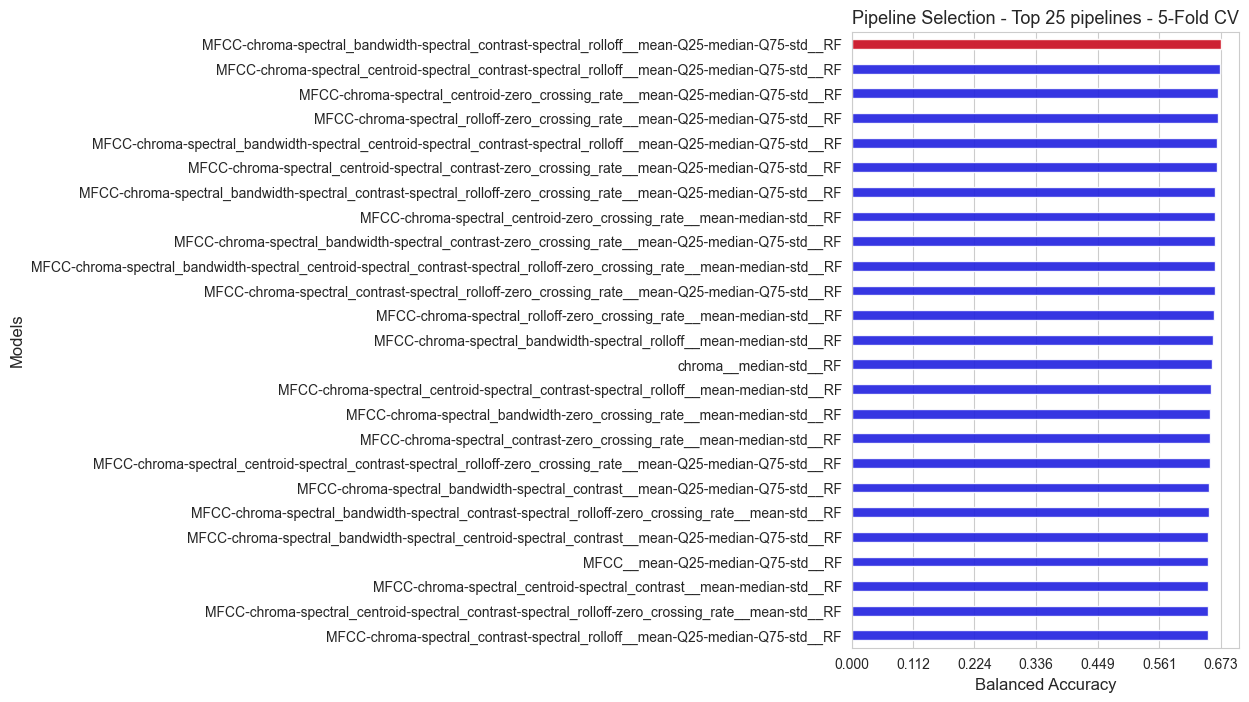

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_bandwidth-spectral_contrast-spectral_rolloff__mean-Q25-median-Q75-std__RF
Balanced accuracy of the best pipeline:  0.673

 Best feature extraction method:  MFCC-chroma-spectral_bandwidth-spectral_contrast-spectral_rolloff 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  RF

The best model hyper-parameters are:  {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 26, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [47]:
n_top = 25

fig, axes = plt.subplots(figsize=(5,8))

ax = sns.barplot(y=sorted_pipelines[0:n_top], x=sorted_scores[0:n_top], color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - Top {n_top} pipelines - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

We save the top 10 method-stats combinations, since they will be the considered combinations to be evaluated in the second round of the inner evaluation.

In [ ]:
top_methods, top_stats = [], []
n_top = 10

for pipeline in sorted_pipelines[0:n_top]:
    top_methods.append(pipeline.split('__')[0])
    top_stats.append(pipeline.split('__')[1])

In [ ]:
# Saving results 
'''
with open('results/top_methods_1', 'wb') as file:
    pickle.dump(top_methods, file)

with open('results/top_stats_1', 'wb') as file:
    pickle.dump(top_stats, file)
'''

### **Inner Evaluation:** ***Round 2***

> **More exhaustive HPO over Random Forest using the top 10 feature extraction methods according to the first round  of the  inner evaluation**

This is the second round of the inner evaluation and is oriented to apply a more exhaustive HPO on Random Forest for the top 10 features extraction methods found on the previous round.

The idea is trying to find an even best version of Random Forest for carrying out our classification task. 

#### **HPO**

We are going to apply an **more exhaustive HPO** over **Random Forest** using the **top 10 features extraction methods** according to the **first round**  of the  **inner evaluation** (the previous one).

In [48]:
with open(f'results/top_methods_1', 'rb') as file:
        top_methods = pickle.load(file)

with open(f'results/top_stats_1', 'rb') as file:
        top_stats = pickle.load(file)

##### HPO for Random Forest

In [ ]:
model = 'RF'

simple_eval = SimpleEvaluation(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid_RF, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123)

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results
# 109 mins

##### Saving the results

In [ ]:
'''
with open('results/best_params_2', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_2', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_2', 'wb') as file:
    pickle.dump(inner_results, file)
'''

##### Opening the results

In [49]:
with open(f'results/best_params_2', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_2', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_2', 'rb') as file:
        inner_results = pickle.load(file)

#### **Selecting the best pipeline**

In [50]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

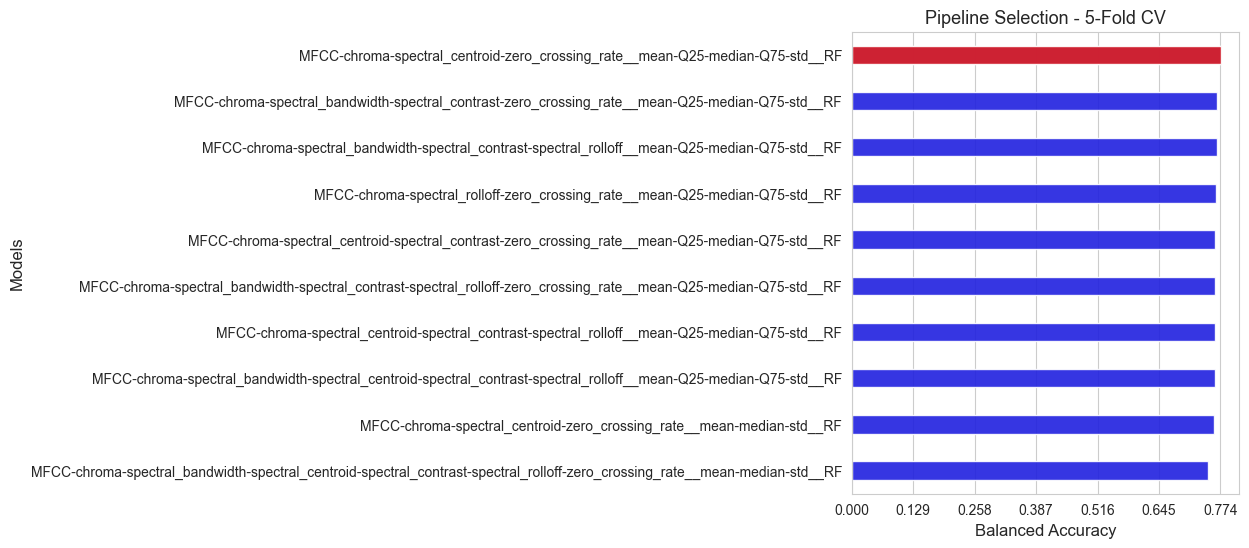

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_centroid-zero_crossing_rate__mean-Q25-median-Q75-std__RF
Balanced accuracy of the best pipeline:  0.774

 Best feature extraction method:  MFCC-chroma-spectral_centroid-zero_crossing_rate 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  RF

The best model hyper-parameters are:  {'n_estimators': 300, 'max_depth': 35, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [51]:
fig, axes = plt.subplots(figsize=(5,6))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

As we can see we have found a better version of Random Forest in this inner evaluation, so we have improved the previous results.

Remind that hte best inner score in the round 1 was a balanced accuracy of 67.3%, and now we have achieved 77.4%.

We save the top 5 features extraction methods to use them in the next inner evaluation round.

In [ ]:
top_methods, top_stats = [], []
n_top = 5

for pipeline in sorted_pipelines[0:n_top]:
    top_methods.append(pipeline.split('__')[0])
    top_stats.append(pipeline.split('__')[1])

In [ ]:
# Saving results 
'''
with open('results/top_methods_2', 'wb') as file:
    pickle.dump(top_methods, file)

with open('results/top_stats_2', 'wb') as file:
    pickle.dump(top_stats, file)
'''

### **Inner Evaluation:** ***Round 3***

> **Finding the best model among XGBoost, Multi Layer Perceptron and two `PyTorch` Neural Networks for our classification task considering only the top 5 features extraction methods obtained in the previous inner evaluation round.**

In [52]:
with open(f'results/top_methods_2', 'rb') as file:
        top_methods = pickle.load(file)

with open(f'results/top_stats_2', 'rb') as file:
        top_stats = pickle.load(file)

#### **Grids for HPO** 

##### Grid for XGBoost

In [ ]:
def param_grid_XGB(trial):

    param_grid = ({
        'max_depth': trial.suggest_categorical('max_depth', [None, 2, 4, 7, 10, 15, 20, 25, 35]),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'n_estimators': trial.suggest_categorical('n_estimators', [75, 100, 150, 200, 250, 300, 350]),
        'eta': trial.suggest_float('eta', 0.001, 0.3, log=True),
        'alpha': trial.suggest_float('alpha', 0.2, 1, log=True)
    })

    return param_grid

##### Grid for Multi Layer Perceptron

In [ ]:
# Grid for Multi-Layer Perceptron
def param_grid_MLP(trial):

    param_grid = ({
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True),
        'alpha': trial.suggest_float('alpha', 0.001, 0.2, log=True),
        'activation': trial.suggest_categorical('activation', ['logistic']),
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [80, 100, 130, 150, 180, 200, 250, 300, 350, 400]),
        'max_iter': trial.suggest_categorical('max_iter', [100, 130, 150, 180, 200, 250, 300, 350, 400])
    })

    return param_grid

##### Grid for Advanced NN (PyTorch)

In [ ]:
def param_grid_Advanced_NN(trial, input_dim, output_dim):

    hidden_layers_choice = trial.suggest_categorical('module__hidden_layers', 
                                                     ['[120, 200]', '[100, 100, 100]',
                                                      '[250, 250, 250]', '[128, 256, 128]', 
                                                      '[128, 256, 128, 220]', '[128, 150, 128, 150]',
                                                      '[300, 150, 300, 150]',
                                                      '[128, 256, 128, 220, 200]'
                                                      ])

    param_grid = ({
        'module__input_dim': trial.suggest_categorical('module__input_dim', [input_dim]),
        'module__output_dim': trial.suggest_categorical('module__output_dim', [output_dim]),
        'module__hidden_layers': eval(hidden_layers_choice),
        'module__dropout_rate': trial.suggest_float('module__dropout_rate', 0.05, 0.6, log=True),
        'lr': trial.suggest_float('lr', 0.0001, 0.01, log=True),
        'max_epochs': trial.suggest_categorical('max_epochs', [75, 100, 130, 150, 175, 200, 250, 300, 350, 400, 450, 500, 600])
    })

    return param_grid

##### Grid for Simple NN (PyTorch)

In [ ]:
def param_grid_Simple_NN(trial, input_dim, output_dim):

    param_grid = ({
        'module__input_dim': trial.suggest_categorical('module__input_dim', [input_dim]),
        'module__output_dim': trial.suggest_categorical('module__output_dim', [output_dim]),
        'module__n_layers': trial.suggest_categorical('module__n_layers', [1, 2, 3, 4, 5, 7]),
        'lr': trial.suggest_float('lr', 0.0001, 0.01, log=True),
        'max_epochs': trial.suggest_categorical('max_epochs', [75, 100, 130, 150, 175, 200, 250, 300, 400])
    })

    return param_grid

#### **HPO**

For each one of the top 5 features extraction methods, that is, predictors matrices, we will apply HPO over the cited models.

##### HPO for Advanced NN (PyTorch)

In [ ]:
model = 'Advanced_NN'

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    input_dim = X_stats_train[method][stat].shape[1]
    output_dim = len(np.unique(Y_train))
    
    simple_eval = SimpleEvaluation(estimator=advanced_NN, param_grid=param_grid_Advanced_NN, 
                    inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                    n_trials=35, random_state=123, 
                    framework='PyTorch', 
                    input_dims=input_dim,
                    output_dims=output_dim)

    simple_eval.fit(X=X_stats_train_pytorch[method][stat], Y=Y_train_pytorch.long())
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

##### HPO for Simple NN (PyTorch)

In [ ]:
model = 'Simple_NN'

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    input_dim = X_stats_train[method][stat].shape[1]
    output_dim = len(np.unique(Y_train))
    
    simple_eval = SimpleEvaluation(estimator=simple_NN, param_grid=param_grid_Simple_NN, 
                    inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                    n_trials=35, random_state=123, 
                    framework='PyTorch', 
                    input_dims=input_dim,
                    output_dims=output_dim)

    simple_eval.fit(X=X_stats_train_pytorch[method][stat], Y=Y_train_pytorch.long())
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

##### HPO for XGBoost

In [ ]:
model = 'XGB'

simple_eval = SimpleEvaluation(estimator=XGBClassifier(random_state=123), param_grid=param_grid_XGB, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123) # n_trials=250

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

##### HPO for Multi Layer Perceptron

In [ ]:
model = 'MLP'

simple_eval = SimpleEvaluation(estimator=MLPClassifier(random_state=123), param_grid=param_grid_MLP, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123)

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

##### Saving the results

In [ ]:
'''
with open('results/best_params_3', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_3', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_3', 'wb') as file:
    pickle.dump(inner_results, file)
'''

##### Opening the results

In [53]:
with open(f'results/best_params_3', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_3', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_3', 'rb') as file:
        inner_results = pickle.load(file)

#### **Selecting the best pipeline**

In this section we are going to select the best pipeline, that is, the best combination of preprocessing techniques and model, in this case the feature extraction methods are the preprocessing techniques.

All the alternatives evaluated are ranked according to their inner scores (balanced accuracy), and   summarized in a plot.

In [54]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

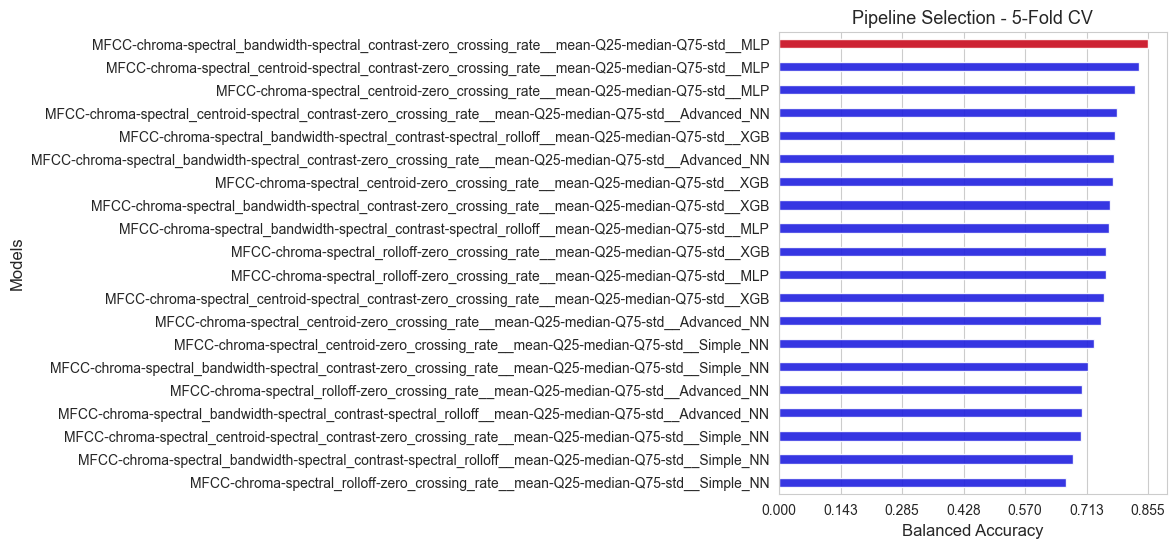

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate__mean-Q25-median-Q75-std__MLP
Balanced accuracy of the best pipeline:  0.855

 Best feature extraction method:  MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  MLP

The best model hyper-parameters are:  {'learning_rate_init': 0.0007230035617449583, 'alpha': 0.0015684955983016854, 'activation': 'logistic', 'hidden_layer_sizes': 300, 'max_iter': 300}


In [55]:
fig, axes = plt.subplots(figsize=(5,6))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

As we can see we have found a better pipeline that in the previous rounds, so we have improved the previous results.

This evaluation tell us that Multi Layer Perceptron seems to work well for our prediction purposes.

### **Inner Evaluation:** ***Round 4***

> **Explore an approach based on sequential data (using MFCC time-varying features), with Recurrent Neural Networks.**



#### **Grids for HPO** 

##### Grid for RNN (PyTorch)

In [ ]:
def param_grid_RNN(trial, input_dim, output_dim):

    param_grid = ({
        'module__input_dim': trial.suggest_categorical('module__input_dim', [input_dim]),
        'module__output_dim': trial.suggest_categorical('module__output_dim', [output_dim]),
        'module__num_layers': trial.suggest_int('module__num_layers', 1, 10),
        'module__hidden_size': trial.suggest_categorical('module__hidden_size', [50, 70, 100, 120, 150, 175, 200, 250]),
        'module__dropout_rate': trial.suggest_float('module__dropout_rate', 0.05, 0.95, log=True),
        'lr': trial.suggest_float('lr', 0.0001, 0.01, log=True),
        'max_epochs': trial.suggest_categorical('max_epochs', [5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100]),
        'batch_size': trial.suggest_categorical('batch_size', [15, 30, 50, 70, 100])
    })

    return param_grid

#### **HPO**

Applying HPO over Recurrent Neural Networks using the MFCC sequencies of features.

##### HPO for RNN (PyTorch)

In [ ]:
model = 'RNN'

input_dim = X_MFCC_tensor_train.shape[2]
output_dim = len(np.unique(Y_train))

simple_eval = SimpleEvaluation(estimator=RNN_model, param_grid=param_grid_RNN, 
                inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                n_trials=50, random_state=123, 
                framework='PyTorch', 
                input_dim=input_dim,
                output_dim=output_dim)

simple_eval.fit(X=X_MFCC_tensor_train, Y=Y_train_tensor.long())
inner_score[model] = simple_eval.inner_score
best_params[model]= simple_eval.inner_best_params
inner_results[model] = simple_eval.inner_results

##### Saving the results

In [ ]:
'''
with open('results/best_params_4', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_4', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_4', 'wb') as file:
    pickle.dump(inner_results, file)
'''

##### Opening the results

In [56]:
with open(f'results/best_params_4', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_4', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_4', 'rb') as file:
        inner_results = pickle.load(file)

#### **Selecting the best pipeline**

In this case we don't have several alternatives to compare, since we have only one, a RNN using sequential features extracted with MFCC method.

The inner obtained balanced accuracy  for the optimal RNN is quite poor, which could be due to a bad specification of the model or the input data.

In [57]:
inner_score

{'RNN': 0.4431818181818182}

### **Inner Evaluation:** ***Round 4***

> **Finding the optimal Multi Layer Perceptron using *standard scaler* as preprocessing technique for the predictors matrices obtained through the top 5 features extraction method that were selected in the round two of the inner evaluation.**

> **The main point is to analyze if standardizing the data helps to improve the MLP performance, since up to now is the best model, and this kind of model usually work better with scaled input data**

In [58]:
with open(f'results/top_methods_2', 'rb') as file:
        top_methods = pickle.load(file)

with open(f'results/top_stats_2', 'rb') as file:
        top_stats = pickle.load(file)

#### **Pipelines**

Here we define a pipeline that incorporates an standard scaler as transformer (preprocessing method) and MLP as estimator (model).

In [ ]:
MLP_pipeline = Pipeline([
    ('scaler', scaler(apply=True, method='standard')),
    ('MLP', MLPClassifier(random_state=123)),
])

#### **Grids for HPO** 

##### Grid for Multi Layer Perceptron

In [ ]:
# Grid for Multi-Layer Perceptron
def param_grid_MLP(trial):

    param_grid = ({
        # preprocessing grid
        'scaler__method': trial.suggest_categorical('scaler__method', ['standard']), # 'min-max' seems to work badly
        # model grid
        'MLP__learning_rate_init': trial.suggest_float('MLP__learning_rate_init', 0.0001, 0.01, log=True),
        'MLP__alpha': trial.suggest_float('MLP__alpha', 0.001, 0.3, log=True),
        'MLP__activation': trial.suggest_categorical('MLP__activation', ['logistic']),
        'MLP__hidden_layer_sizes': trial.suggest_categorical('MLP__hidden_layer_sizes', [80, 100, 130, 150, 180, 200, 250, 300, 350, 400]),
        'MLP__max_iter': trial.suggest_categorical('MLP__max_iter', [100, 130, 150, 180, 200, 250, 300, 350, 400, 450, 500, 550])
    })

    return param_grid

#### **HPO**

We are going to apply HPO over MLP for the **top 5** feature extraction methods according to the **round 2 inner evaluation**, as we did in round 3, but now **standardizing** the input data.

##### HPO for Multi Layer Perceptron

In [ ]:
model = 'MLP_scaled'

simple_eval = SimpleEvaluation(estimator=MLP_pipeline, param_grid=param_grid_MLP, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=250, random_state=123)

for method, stat in zip(top_methods, top_stats):

    print('-------------------------------------------------------------------------------')
    print(method, stat, model)
    print('-------------------------------------------------------------------------------')

    simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
    inner_score[method][stat][model] = simple_eval.inner_score
    best_params[method][stat][model]= simple_eval.inner_best_params
    inner_results[method][stat][model] = simple_eval.inner_results

##### Saving the results

In [ ]:
'''
with open('results/best_params_5', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_5', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_5', 'wb') as file:
    pickle.dump(inner_results, file)
'''

##### Opening the results

In [61]:
with open(f'results/best_params_5', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_5', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_5', 'rb') as file:
        inner_results = pickle.load(file)

#### **Selecting the best pipeline**

In this section we are going to select the best pipeline, that is, the best combination of preprocessing techniques and model, in this case the feature extraction methods are the preprocessing techniques.

All the alternatives evaluated are ranked according to their inner scores (balanced accuracy), and   summarized in a plot.

In [62]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

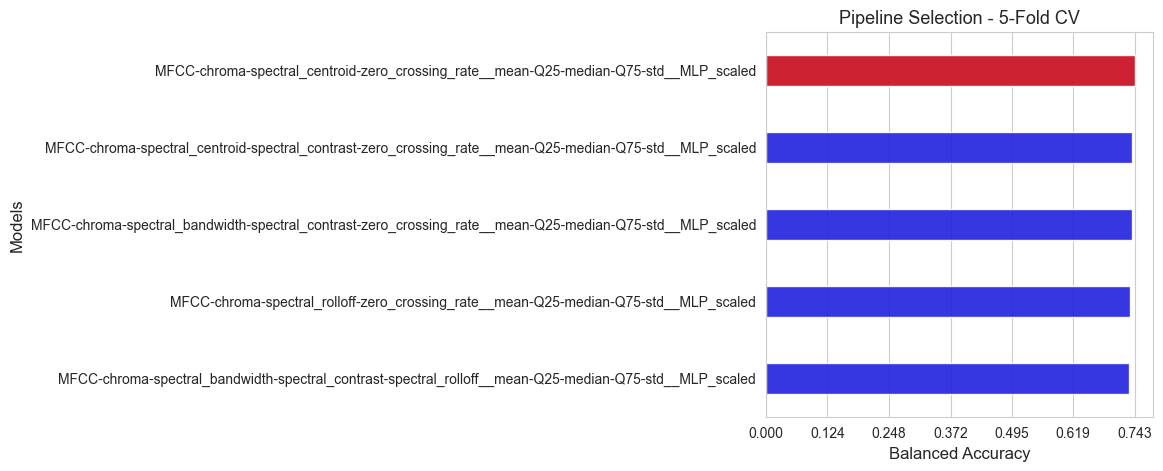

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_centroid-zero_crossing_rate__mean-Q25-median-Q75-std__MLP_scaled
Balanced accuracy of the best pipeline:  0.743

 Best feature extraction method:  MFCC-chroma-spectral_centroid-zero_crossing_rate 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  MLP_scaled

The best model hyper-parameters are:  {'scaler__method': 'standard', 'MLP__learning_rate_init': 0.007698005277655154, 'MLP__alpha': 0.0014043387552593086, 'MLP__activation': 'logistic', 'MLP__hidden_layer_sizes': 100, 'MLP__max_iter': 300}


In [63]:
fig, axes = plt.subplots(figsize=(5,5))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

As we can see that MLP doesn't work better standardizing the input data, at least in this case. 

### **Selecting the best overall pipeline**

> We rank the all the alternatives that we have evaluated (1046 in total!) according to their inner balanced accuracy, and highlight the best one, that will be the one chosen as final pipeline, and it would be the one we would use for classifying new patients.

In [64]:
inner_score, best_params, inner_results = {}, {}, {}

rounds = [1,2,3,4,5]

for round in rounds:

    with open(f'results/best_params_{round}', 'rb') as file:
            best_params[round] = pickle.load(file)

    with open(f'results/inner_scores_{round}', 'rb') as file:
            inner_score[round] = pickle.load(file)

    with open(f'results/inner_results_{round}', 'rb') as file:
            inner_results[round] = pickle.load(file)

In [65]:
inner_score_flatten, best_params_flatten, inner_results_flatten = {}, {}, {}

for round in [1,2,3,5]:

    inner_score_flatten.update({key1 + '__' + key2 + '__' + key3 : inner_score[round][key1][key2][key3]  
                        for key1 in inner_score[round].keys() 
                        for key2 in inner_score[round][key1].keys() 
                        for key3 in inner_score[round][key1][key2].keys()})
        
    best_params_flatten.update({key1 + '__' + key2 + '__' + key3 : best_params[round][key1][key2][key3]  
                        for key1 in best_params[round].keys() 
                        for key2 in best_params[round][key1].keys() 
                        for key3 in best_params[round][key1][key2].keys()})
    
    inner_results_flatten.update({key1 + '__' + key2 + '__' + key3 : inner_results[round][key1][key2][key3]  
                            for key1 in inner_results[round].keys() 
                            for key2 in inner_results[round][key1].keys() 
                            for key3 in inner_results[round][key1][key2].keys()})
    
inner_score_flatten.update(inner_score[4])
best_params_flatten.update(best_params[4])
inner_results_flatten.update(inner_results[4])

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True)  # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

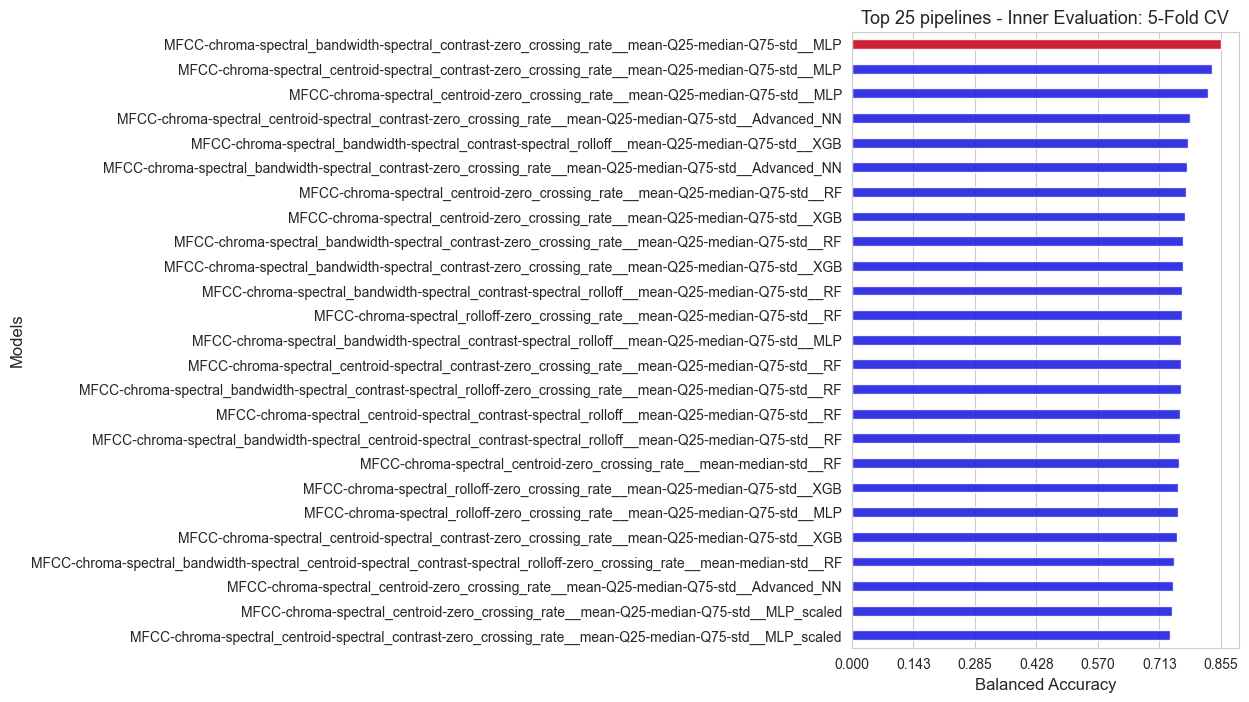

The best pipeline among all the 1046 alternatives, according to the inner evaluation, is: MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate__mean-Q25-median-Q75-std__MLP
Balanced accuracy of the best pipeline:  0.855

 Best feature extraction method:  MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  MLP

 The best model hyper-parameters are:  {'learning_rate_init': 0.0007230035617449583, 'alpha': 0.0015684955983016854, 'activation': 'logistic', 'hidden_layer_sizes': 300, 'max_iter': 300}


In [66]:
n_top = 25

fig, axes = plt.subplots(figsize=(5,8))

ax = sns.barplot(y=sorted_pipelines[0:n_top], x=sorted_scores[0:n_top], color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Top {n_top} pipelines - Inner Evaluation: 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline among all the {len(sorted_scores)} alternatives, according to the inner evaluation, is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)
print('\n The best model hyper-parameters are: ', best_params_flatten[best_pipeline])

The next step is to make an **estimation of the future performance** of the best pipeline, that is, how it would work classifying the level of PD of new patients, based in their voice. This part is called **outer evaluation**.

In [67]:
# Saving results 

with open('results/final_best_method', 'wb') as file:
    pickle.dump(best_method, file)

with open('results/final_best_stats', 'wb') as file:
    pickle.dump(best_stats, file)

with open('results/final_best_model', 'wb') as file:
    pickle.dump(best_model, file)


### **Outer Evaluation**

> **The next step is to make an ***estimation of the future performance*** of the best pipeline, that is, how it would work classifying the level of PD of new patients, based in their voice. This part is called ***outer evaluation***.**

In [8]:
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Audio Analysis\Parkinson_Severity_Classification\results\final_best_method', 'rb') as file:
            final_best_method = pickle.load(file)

with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Audio Analysis\Parkinson_Severity_Classification\results\final_best_stats', 'rb') as file:
        final_best_stats = pickle.load(file)

with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Audio Analysis\Parkinson_Severity_Classification\results\final_best_model', 'rb') as file:
        final_best_model = pickle.load(file)

with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Audio Analysis\Parkinson_Severity_Classification\results\best_params_3', 'rb') as file:
        best_params = pickle.load(file)

We print the saved results in order to review which is the best pipeline, namely, the best combination of feature extraction method and model (with its hyper-parameters).

In [9]:
print(f'Best features extraction method is the combined method {final_best_method} with the statistics {final_best_stats}')

print(f'\nAnd the best model is {final_best_model} with the following hyper-parameters:\n{best_params[final_best_method][final_best_stats][final_best_model]}')

Best features extraction method is the combined method MFCC-chroma-spectral_bandwidth-spectral_contrast-zero_crossing_rate with the statistics mean-Q25-median-Q75-std

And the best model is MLP with the following hyper-parameters:
{'learning_rate_init': 0.0007230035617449583, 'alpha': 0.0015684955983016854, 'activation': 'logistic', 'hidden_layer_sizes': 300, 'max_iter': 300}


- Estimation of future performance based on the testing partition:

In [ ]:
MLP_model = MLPClassifier(random_state=123).set_params(**best_params[final_best_method][final_best_stats][final_best_model])
MLP_model.fit(X=X_stats_train[final_best_method][final_best_stats], y=Y_train)
Y_test_hat = MLP_model.predict(X=X_stats_test[final_best_method][final_best_stats])
future_performance_balanced_acc = balanced_accuracy_score(y_pred=Y_test_hat, y_true=Y_test)
future_performance_acc = accuracy_score(y_pred=Y_test_hat, y_true=Y_test)

In [44]:
print(f'The estimation of future performance of the best pipeline in terms of balanced accuracy is {int(np.round(future_performance_balanced_acc, 2)*100)}%, and in terms of accuracy is {int(np.round(future_performance_acc, 2)*100)}%.')

The estimation of future performance of the best pipeline in terms of balanced accuracy is 83%, and in terms of accuracy is 85%.


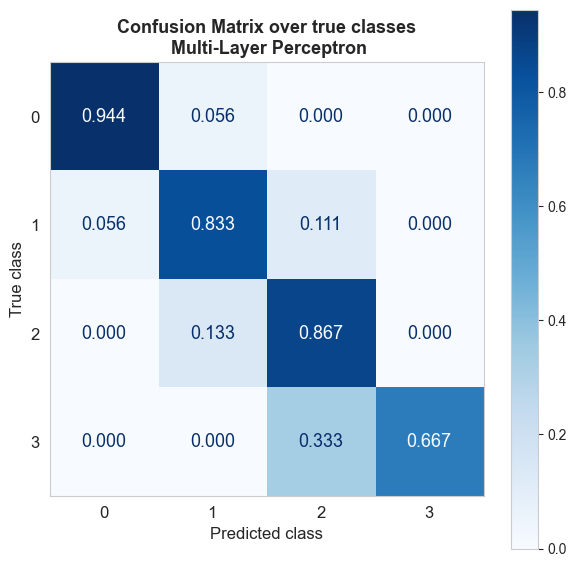

In [27]:
cm = confusion_matrix(y_pred=Y_test_hat, y_true=Y_test, normalize='true', labels=MLP_model.classes_)
# normalize='true' to normalize over the rows (true classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MLP_model.classes_)

fig, axs = plt.subplots(figsize=(7,7))
disp.plot(ax=axs, cmap=plt.cm.Blues, values_format='.3f', text_kw={'fontsize': 13})
plt.title('Confusion Matrix over true classes\n Multi-Layer Perceptron', weight='bold', fontsize=13)
axs.set_xlabel('Predicted class', size=12)
axs.set_ylabel('True class', size=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()

The results of the confusion matrix are generally good, these results were expected based on the estimation of future performance. The errors made by the model are localized, there are no major confusions. The error is always one level.

The class that produces the biggest error is class 3 (severe level), it seems that the model does not recognize this class too well, something that may be due to an unbalance of this class, there are fewer samples of this class so the model maybe does not capture the characteristics that differentiate this class from class 2. With some kind of class balancing or weights, the accuracy in that class could be increased if necessary.

## **Final Model**

### **Saving the final model**

In [ ]:
# Initializing th ebest model with its best params
final_model = MLPClassifier(random_state=123).set_params(**best_params[final_best_method][final_best_stats][final_best_model])
# Training the model with all the available data, using the predictors matrix obtained with the best method for feature extraction
final_model.fit(X=X_stats[final_best_method][final_best_stats], y=Y)
# Saving the model already initialized and trained
joblib.dump(final_model, r"C:\Users\fscielzo\Documents\DataScience-GitHub\Audio Analysis\Parkinson_Severity_Classification\results\final_model.joblib")

### **Predicting new data**

- Loading the saved model

In [18]:
final_model = joblib.load(r"C:\Users\fscielzo\Documents\DataScience-GitHub\Audio Analysis\Parkinson_Severity_Classification\results\final_model.joblib")

- Loading a new audio and extracting its features to be used for predicting its class.

In [20]:
# This audio plays the role of a new patient audio 
new_audio_file = 'PDSpeechData/loc17/loc17_s01.wav' 

# Extracting features of the new audio using the final (best) method-stats.
individual_methods = final_best_method.split('-')
X_stats_new = {}
for method in individual_methods:
    X_stats_new[method] = get_X_audio_features(paths=[new_audio_file], method=method, stats=final_best_stats, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

X_stats_new[final_best_method] = np.column_stack([X_stats_new[method] for method in individual_methods])

In [21]:
X_stats_new[final_best_method]

array([[-1.85570816e+02,  9.09455872e+01, -2.44680901e+01,
        -7.04029322e+00, -1.81235161e+01,  1.39041967e+01,
        -2.44391179e+00, -5.16143751e+00,  2.11006179e-01,
        -7.74400330e+00,  2.35691810e+00, -2.67633553e+01,
         5.93925667e+00, -1.15721340e+01, -4.94519901e+00,
         5.14253676e-01, -5.60667944e+00, -6.44442844e+00,
        -1.17365682e+00, -7.13852310e+00, -1.89633648e+02,
         8.78949642e+01, -2.86219001e+01, -8.75667405e+00,
        -2.10318441e+01,  1.22900267e+01, -4.22333467e+00,
        -7.48853457e+00, -2.43984455e+00, -9.48855925e+00,
         1.24283183e+00, -2.94770994e+01,  4.33485985e+00,
        -1.30440550e+01, -6.32022858e+00, -8.08254302e-01,
        -6.70881236e+00, -8.22138071e+00, -2.99997491e+00,
        -8.18231726e+00, -1.78737259e+02,  9.08615875e+01,
        -2.59062710e+01, -7.23408175e+00, -1.86913033e+01,
         1.43382187e+01, -1.84077740e+00, -5.62563133e+00,
         9.03636396e-01, -7.57154369e+00,  2.89028454e+0

In [22]:
X_stats_new[final_best_method].shape

(1, 205)

- We predict the new audio with the pre-trained model.

In [23]:
final_model.predict(X=X_stats_new[final_best_method])

array([0], dtype=int64)

The new patient is predicted as class 0 (normal level of PD).

## **Conclusions**

We have compared the different models trained during the assignment. In the first parts we have used the Gaussian Processes and Random Forest, which have generated acceptable results. Especially the Gaussian Processes, which are close to 80%, although the way of evaluating them is not very correct and could be due to chance. The models in the last part are varied, due to the wide range of models tested, both good and bad. 

The best models obtained correspond to Dense Neural Networks. These models generate a future performance estimate of 83% (in terms of balanced accuracy), which is a good result. In fact, one could explore the possibility of finding some kind of neural network that works better for these data, which could further improve these data. This could be an interesting direction for further study.